In [1]:
#!pip3 install accelerate transformers[pytorch] PyTorch optuna wandb datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import optuna 
from optuna import trial
import random
import os 
import pickle

import torch.cuda
import torch
from torch import nn

import wandb
wandb.login()

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import TrainerCallback
from transformers import set_seed

from sklearn.metrics import (accuracy_score,
                            f1_score,
                            precision_score,
                            recall_score,
                            precision_recall_curve,
                            auc, 
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            balanced_accuracy_score,
                            classification_report)

from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict
from accelerate import Accelerator
from numpy.random import seed
from lightning.pytorch import seed_everything
import time

/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: joelyacob91 (master-2024). Use `wandb login --relogin` to force relogin
2024-04-19 19:28:08.470979: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"

In [4]:
def model_init():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=3)
    model.to(device)
    return model

In [5]:
model_init()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, e

In [6]:
!nvidia-smi

Fri Apr 19 19:29:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                On  | 00000000:A1:00.0 Off |                  Off |
| 33%   30C    P2              69W / 260W |    269MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
print(torch.cuda.device_count())

1


In [8]:
print(os.getcwd())

/net/fs-2/scale/OrionStore/Home/joteklem/Pytorch_models


In [9]:
with open('/net/fs-2/scale/OrionStore/Home/joteklem/Preprocessing/BERT_dataset_15.pkl', 'rb') as f:
    encoded_dataset_15 = pickle.load(f)
encoded_dataset_15

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10078
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3360
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3360
    })
})

In [10]:
with open('/net/fs-2/scale/OrionStore/Home/joteklem/Preprocessing/BERT_dataset_30.pkl', 'rb') as f:
    encoded_dataset_30 = pickle.load(f)
encoded_dataset_30

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10128
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3376
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3376
    })
})

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [12]:
#encoded_df_15 = pd.read_csv('/net/fs-2/scale/OrionStore/Home/joteklem/Datasets/all_leagues_df_15sec.csv')
#encoded_df_15['encoded_label'] = encoded_df_15['label'].astype('category').cat.codes
#encoded_df_15 = encoded_df_15[['ASR_text', 'encoded_label']]
#encoded_df_15.columns

In [13]:
#encoded_df_30 = pd.read_csv('/net/fs-2/scale/OrionStore/Home/joteklem/Datasets/all_leagues_df_30sec.csv')
#encoded_df_30['encoded_label'] = encoded_df_30['label'].astype('category').cat.codes
#encoded_df_30 = encoded_df_30[['ASR_text', 'encoded_label']]
#encoded_df_30.columns

In [14]:
#class_weights_15 = (1 - (encoded_df_15['encoded_label'].value_counts().sort_index() / len(encoded_df_15['encoded_label']))).values
#class_weights_15

In [15]:
#class_weights_30 = (1 - (encoded_df_30['encoded_label'].value_counts().sort_index() / len(encoded_df_30['encoded_label']))).values
#class_weights_30

In [16]:
# Since they are the approximately the same we can have the same class weight for bothn of the classes.

In [17]:
#class_weights = class_weights_15
#class_weights = torch.from_numpy(class_weights_15).float().to('cuda')
#class_weights

In [18]:
#class WeightedLossTrainer(Trainer):
#  def Loss(self, model, input, return_outputs=False):

    # Feed input to model and extract logits
#    outputs = model(**inputs)
#    logits = outputs.get('logits')

    # Extract labels
#    labels = inputs.get('labels')

    # Define loss function with class weights
#    loss_func = nn.CrossEntropyLoss(weight=class_weights)

    # Compute loss
#    loss = loss_func(logits, labels)

#    return (loss, ouputs) if return_outputs else loss

In [19]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(-1)

    # F1-Score
    f1 = f1_score(labels, preds, average="weighted", zero_division=0)
    f1_macro = f1_score(labels, preds, average="macro", zero_division=0)
    f1_micro = f1_score(labels, preds, average="micro", zero_division=0)

    # Precision
    #precision = precision_score(labels, preds, average='weighted')
    #precision_macro = precision_score(labels, preds, average='macro')
    #precision_micro = precision_score(labels, preds, average='micro')

    # Recall
    #recall = recall_score(labels, preds, average='weighted')
    #recall_macro = recall_score(labels, preds, average='macro')
    #recall_micro = recall_score(labels, preds, average='micro')

    # Accuracy
    acc = accuracy_score(labels, preds)
    bal_acc = balanced_accuracy_score(labels, preds)

    # Classification report 
    class_report = classification_report(labels, preds, output_dict=True, zero_division=0)
    
    return {"Accuracy": acc,
            "Balanced accuracy": bal_acc,
            "F1 weighted": f1,
            'F1 macro':f1_macro,
            'F1 micro':f1_micro,
            #'Recall': recall,
            #'Precision': precision,
            "Classification Report": class_report}

In [20]:
class LossTrackingCallback(TrainerCallback):
    """Logs aggregate metrics after each epoch."""
    def __init__(self):
        super().__init__()
        # Initialize lists to store all values temporarily
        self._training_losses = []
        self._validation_losses = []
        # Initialize variables to store final or average values
        self.final_training_loss = None
        self.final_validation_loss = None

    def on_epoch_end(self, args, state, control, **kwargs):
        # Compute final or average losses here and store them in instance variables
        if self._training_losses:
            self.final_training_loss = self._training_losses[-1] 
        if self._validation_losses:
            self.final_validation_loss = self._validation_losses[-1]  

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Temporarily store all loss values
        if 'loss' in logs:
            self._training_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self._validation_losses.append(logs['eval_loss'])

loss_metric = LossTrackingCallback()

In [21]:
class OptunaCallback(TrainerCallback):
    def __init__(self, trial):
        self.trial = trial

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Report the intermediate value to Optuna
        self.trial.report(metrics['eval_F1 weighted'], step=state.epoch)
        # Check if the current trial should be pruned
        if self.trial.should_prune():
            raise optuna.exceptions.TrialPruned()

In [22]:

def objective_closure(data):
    """
    A closure for the objective function to include the dataset.
    """
    def objective(trial):
        
        wandb.init(project='MiniLM', config=trial.params, name=f"trial-{trial.number}")
         
        print(f"Starting trial {trial.number}")
        
        # Hyperparameter suggestions
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32])
        weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
        num_train_epochs = trial.suggest_categorical('num_train_epochs', [2, 3, 4, 5])
        warmup_steps = trial.suggest_int('warmup_steps', 0, 500)
    
        model_name = f"{model_ckpt}-finetuned-ASR_text"
        
        # Setup training arguments
        training_args = TrainingArguments(
            output_dir=model_name,  
            num_train_epochs=num_train_epochs,
            learning_rate=learning_rate,
            per_device_train_batch_size=per_device_train_batch_size,
            per_device_eval_batch_size=per_device_train_batch_size,
            weight_decay=weight_decay,
            warmup_steps=warmup_steps,
            evaluation_strategy="epoch",
            gradient_accumulation_steps=2,
            fp16=True,
            disable_tqdm=False,
            logging_steps=len(data['train']) // per_device_train_batch_size,
            log_level="error",
            report_to="wandb", 
            seed=23
        )
    
        # Initialize the Trainer
        trainer = Trainer(
            model_init=model_init,
            args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=data['train'],
            eval_dataset=data['validation'],
            callbacks=[OptunaCallback(trial),loss_metric],
            tokenizer=tokenizer,
        )
    
        # Train the model
        trainer.train()
    
        # Evaluate the model
        eval_results = trainer.evaluate()

        # Retrieve metrics for multi-objective optimization
        f1_macro = eval_results.get('eval_F1 macro')
        trial.set_user_attr('eval_F1 macro',f1_macro)
        
        training_loss = loss_metric.final_training_loss
        validation_loss = loss_metric.final_validation_loss

        # Check if the current trial is the best
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        print(f"Completed trial {trial.number}")

        wandb.log({"macro F1 score": f1_macro})
        wandb.log({"Training loss":training_loss, "Validation loss":validation_loss})
            
        wandb.finish()
        
        # Return the primary metric for optimization
        return f1_macro
     
    return objective

In [23]:
# Seed
sampler = optuna.samplers.TPESampler(seed=42)

# Enable Optuna's default logging
optuna.logging.enable_default_handler()

# Create the study with a pruner
pruner = optuna.pruners.MedianPruner()

study_15 = optuna.create_study(
    direction="maximize",
    study_name='MiniLM_15_study',
    storage='sqlite:///MiniLM_15.db',
    pruner=pruner, sampler=sampler
)

study_30 = optuna.create_study(
    direction="maximize",
    study_name='MiniLM_30_study',
    storage='sqlite:///MiniLM_30.db',
    pruner=pruner, sampler=sampler
)

[I 2024-04-19 19:29:21,104] A new study created in RDB with name: MiniLM_15_study
[I 2024-04-19 19:29:21,853] A new study created in RDB with name: MiniLM_30_study


In [24]:
# Get the objective function with your dataset included
objective_15 = objective_closure(encoded_dataset_15)

start_study_15 = time.time()
study_15.optimize(objective_15, n_trials=32) #, timeout=600)  
end_study_15 = time.time()

model_time_study_15 = end_study_15 - start_study_15

/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 0


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.529789,0.796726,0.661856,0.785796,0.699250,0.796726,"{'0': {'precision': 0.7588652482269503, 'recall': 0.5957683741648107, 'f1-score': 0.6674984404242046, 'support': 898.0}, '1': {'precision': 0.8135179153094463, 'recall': 0.9297347603536529, 'f1-score': 0.8677524429967426, 'support': 2149.0}, '2': {'precision': 0.7236180904522613, 'recall': 0.46006389776357826, 'f1-score': 0.5625, 'support': 313.0}, 'accuracy': 0.7967261904761904, 'macro avg': {'precision': 0.7653337513295527, 'recall': 0.6618556774273473, 'f1-score': 0.6992502944736491, 'support': 3360.0}, 'weighted avg': {'precision': 0.7905367426248092, 'recall': 0.7967261904761904, 'f1-score': 0.7857964581848021, 'support': 3360.0}}"
2,0.599400,0.500553,0.821131,0.738492,0.816941,0.758109,0.821131,"{'0': {'precision': 0.7589285714285714, 'recall': 0.6625835189309577, 'f1-score': 0.7074910820451843, 'support': 898.0}, '1': {'precision': 0.852060737527115, 'recall': 0.9139134481154025, 'f1-score': 0.8819039066008083, 'support': 2149.0}, '2': {'precision': 0.7380073800738007, 'recall': 0.6389776357827476, 'f1-score': 0.684931506849315, 'support': 313.0}, 'accuracy': 0.8211309523809524, 'macro avg': {'precision': 0.7829988963431624, 'recall': 0.7384915342763693, 'f1-score': 0.7581088318317692, 'support': 3360.0}, 'weighted avg': {'precision': 0.8165454440630139, 'recall': 0.8211309523809524, 'f1-score': 0.8169410858945084, 'support': 3360.0}}"
3,0.599400,0.517451,0.819940,0.751439,0.816230,0.760682,0.819940,"{'0': {'precision': 0.762778505897772, 'recall': 0.6481069042316259, 'f1-score': 0.7007826610475617, 'support': 898.0}, '1': {'precision': 0.854831657192829, 'recall': 0.9097254536993951, 'f1-score': 0.881424706943192, 'support': 2149.0}, '2': {'precision': 0.7032258064516129, 'recall': 0.6964856230031949, 'f1-score': 0.6998394863563403, 'support': 313.0}, 'accuracy': 0.8199404761904762, 'macro avg': {'precision': 0.7736119898474046, 'recall': 0.751439326978072, 'f1-score': 0.7606822847823648, 'support': 3360.0}, 'weighted avg': {'precision': 0.8161065497092094, 'recall': 0.8199404761904762, 'f1-score': 0.8162304416878466, 'support': 3360.0}}"
4,0.309900,0.594812,0.812798,0.737049,0.809891,0.752259,0.812798,"{'0': {'precision': 0.7237635705669482, 'recall': 0.6681514476614699, 'f1-score': 0.6948465547191662, 'support': 898.0}, '1': {'precision': 0.8554323725055433, 'recall': 0.8976268031642625, 'f1-score': 0.8760217983651226, 'support': 2149.0}, '2': {'precision': 0.7318840579710145, 'recall': 0.645367412140575, 'f1-score': 0.6859083191850595, 'support': 313.0}, 'accuracy': 0.812797619047619, 'macro avg': {'precision': 0.7703600003478354, 'recall': 0.7370485543221026, 'f1-score': 0.7522588907564494, 'support': 3360.0}, 'weighted avg': {'precision': 0.8087332038775177, 'recall': 0.812797619047619, 'f1-score': 0.8098905817646975, 'support': 3360.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 0


Training loss,▁
Validation loss,▁
eval/Accuracy,▁██▆▆
eval/Balanced accuracy,▁▇█▇▇
eval/F1 macro,▁██▇▇
eval/F1 micro,▁██▆▆
eval/F1 weighted,▁██▆▆
eval/loss,▃▁▂██
eval/runtime,█▁▅▁▂
eval/samples_per_second,▁█▄█▇
eval/steps_per_second,▁█▄█▇


[I 2024-04-19 19:31:56,682] Trial 0 finished with value: 0.7522588907564494 and parameters: {'learning_rate': 5.6115164153345e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.04680559213273095, 'num_train_epochs': 4, 'warmup_steps': 354}. Best is trial 0 with value: 0.7522588907564494.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 1


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.626313,0.755655,0.556961,0.730661,0.592573,0.755655,"{'0': {'precision': 0.6504992867332382, 'recall': 0.5077951002227171, 'f1-score': 0.5703564727954972, 'support': 898.0}, '1': {'precision': 0.7822706065318819, 'recall': 0.9362494183341089, 'f1-score': 0.8523617877568311, 'support': 2149.0}, '2': {'precision': 0.8160919540229885, 'recall': 0.2268370607028754, 'f1-score': 0.35500000000000004, 'support': 313.0}, 'accuracy': 0.7556547619047619, 'macro avg': {'precision': 0.7496206157627029, 'recall': 0.5569605264199005, 'f1-score': 0.5925727535174428, 'support': 3360.0}, 'weighted avg': {'precision': 0.7502037721823386, 'recall': 0.7556547619047619, 'f1-score': 0.7306608912082698, 'support': 3360.0}}"
2,0.693200,0.547708,0.788393,0.701811,0.785618,0.711404,0.788393,"{'0': {'precision': 0.6996381182147166, 'recall': 0.6458797327394209, 'f1-score': 0.671685002895194, 'support': 898.0}, '1': {'precision': 0.8424107142857142, 'recall': 0.8780828292228944, 'f1-score': 0.859876965140123, 'support': 2149.0}, '2': {'precision': 0.6254295532646048, 'recall': 0.5814696485623003, 'f1-score': 0.6026490066225165, 'support': 313.0}, 'accuracy': 0.7883928571428571, 'macro avg': {'precision': 0.7224927952550119, 'recall': 0.7018107368415386, 'f1-score': 0.7114036582192779, 'support': 3360.0}, 'weighted avg': {'precision': 0.7840402099192371, 'recall': 0.7883928571428571, 'f1-score': 0.7856184136187072, 'support': 3360.0}}"
3,0.693200,0.526848,0.803869,0.700232,0.796809,0.723818,0.803869,"{'0': {'precision': 0.7664335664335664, 'recall': 0.6102449888641426, 'f1-score': 0.6794792312461252, 'support': 898.0}, '1': {'precision': 0.8290634187316254, 'recall': 0.9185667752442996, 'f1-score': 0.8715231788079469, 'support': 2149.0}, '2': {'precision': 0.678030303030303, 'recall': 0.5718849840255591, 'f1-score': 0.6204506065857885, 'support': 313.0}, 'accuracy': 0.8038690476190476, 'macro avg': {'precision': 0.7578424293984982, 'recall': 0.7002322493780003, 'f1-score': 0.7238176722132869, 'support': 3360.0}, 'weighted avg': {'precision': 0.7982553911785985, 'recall': 0.8038690476190476, 'f1-score': 0.7968085418984078, 'support': 3360.0}}"
4,0.491800,0.525043,0.805952,0.711099,0.800893,0.726394,0.805952,"{'0': {'precision': 0.7634408602150538, 'recall': 0.6325167037861915, 'f1-score': 0.6918392204628502, 'support': 898.0}, '1': {'precision': 0.8404987102321582, 'recall': 0.9097254536993951, 'f1-score': 0.8737430167597765, 'support': 2149.0}, '2': {'precision': 0.6379310344827587, 'recall': 0.5910543130990416, 'f1-score': 0.6135986733001658, 'support': 313.0}, 'accuracy': 0.805952380952381, 'macro avg': {'precision': 0.7472902016433235, 'recall': 0.7110988235282094, 'f1-score': 0.7263936368409308, 'support': 3360.0}, 'weighted avg': {'precision': 0.8010339388556932, 'recall': 0.805952380952381, 'f1-score': 0.8008933773021879, 'support': 3360.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 1


Training loss,▁
Validation loss,▁
eval/Accuracy,▁▆███
eval/Balanced accuracy,▁████
eval/F1 macro,▁▇███
eval/F1 micro,▁▆███
eval/F1 weighted,▁▆███
eval/loss,█▃▁▁▁
eval/runtime,▁▃█▃▄
eval/samples_per_second,█▆▁▆▅
eval/steps_per_second,█▆▁▆▅


[I 2024-04-19 19:34:33,661] Trial 1 finished with value: 0.7263936368409308 and parameters: {'learning_rate': 1.0994335574766187e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.05454749016213018, 'num_train_epochs': 4, 'warmup_steps': 145}. Best is trial 0 with value: 0.7522588907564494.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 2


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.557082,0.780655,0.684847,0.772678,0.681963,0.780655,"{'0': {'precision': 0.8204667863554758, 'recall': 0.5089086859688196, 'f1-score': 0.6281786941580755, 'support': 898.0}, '1': {'precision': 0.8193924261339992, 'recall': 0.9162401116798511, 'f1-score': 0.8651142355008788, 'support': 2149.0}, '2': {'precision': 0.4925, 'recall': 0.6293929712460063, 'f1-score': 0.552594670406732, 'support': 313.0}, 'accuracy': 0.7806547619047619, 'macro avg': {'precision': 0.7107864041631583, 'recall': 0.6848472562982257, 'f1-score': 0.6819625333552288, 'support': 3360.0}, 'weighted avg': {'precision': 0.7892279755682087, 'recall': 0.7806547619047619, 'f1-score': 0.7726777057388832, 'support': 3360.0}}"
1,0.620000,0.509968,0.806548,0.715060,0.800831,0.727608,0.806548,"{'0': {'precision': 0.7704225352112676, 'recall': 0.60913140311804, 'f1-score': 0.6803482587064676, 'support': 898.0}, '1': {'precision': 0.8403755868544601, 'recall': 0.9162401116798511, 'f1-score': 0.8766696349065004, 'support': 2149.0}, '2': {'precision': 0.6319218241042345, 'recall': 0.6198083067092651, 'f1-score': 0.6258064516129032, 'support': 313.0}, 'accuracy': 0.8065476190476191, 'macro avg': {'precision': 0.7475733153899874, 'recall': 0.7150599405023854, 'f1-score': 0.7276081150752903, 'support': 3360.0}, 'weighted avg': {'precision': 0.8022613403912435, 'recall': 0.8065476190476191, 'f1-score': 0.8008313098474156, 'support': 3360.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 1.9936507936507937 is already reported.
  warnings.warn(


Completed trial 2


Training loss,▁
Validation loss,▁
eval/Accuracy,▁██
eval/Balanced accuracy,▁██
eval/F1 macro,▁██
eval/F1 micro,▁██
eval/F1 weighted,▁██
eval/loss,█▁▁
eval/runtime,▁▄█
eval/samples_per_second,█▅▁
eval/steps_per_second,█▅▁


[I 2024-04-19 19:35:06,668] Trial 2 finished with value: 0.7276081150752903 and parameters: {'learning_rate': 0.00016738085788752134, 'per_device_train_batch_size': 32, 'weight_decay': 0.13682099526511077, 'num_train_epochs': 2, 'warmup_steps': 23}. Best is trial 0 with value: 0.7522588907564494.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 3


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.573165,0.783036,0.674215,0.772236,0.686960,0.783036,"{'0': {'precision': 0.8003472222222222, 'recall': 0.5133630289532294, 'f1-score': 0.6255088195386703, 'support': 898.0}, '1': {'precision': 0.8083807973962571, 'recall': 0.9246161005118659, 'f1-score': 0.8626003907097896, 'support': 2149.0}, '2': {'precision': 0.5613496932515337, 'recall': 0.5846645367412141, 'f1-score': 0.5727699530516432, 'support': 313.0}, 'accuracy': 0.7830357142857143, 'macro avg': {'precision': 0.7233592376233378, 'recall': 0.6742145554021032, 'f1-score': 0.6869597211000343, 'support': 3360.0}, 'weighted avg': {'precision': 0.7832216051035246, 'recall': 0.7830357142857143, 'f1-score': 0.7722357603828061, 'support': 3360.0}}"
1,0.666600,0.492333,0.814583,0.712993,0.808622,0.736167,0.814583,"{'0': {'precision': 0.7724230254350736, 'recall': 0.6425389755011136, 'f1-score': 0.7015197568389058, 'support': 898.0}, '1': {'precision': 0.8418367346938775, 'recall': 0.9213587715216379, 'f1-score': 0.8798044878915797, 'support': 2149.0}, '2': {'precision': 0.6896551724137931, 'recall': 0.5750798722044729, 'f1-score': 0.6271777003484322, 'support': 313.0}, 'accuracy': 0.8145833333333333, 'macro avg': {'precision': 0.7679716441809147, 'recall': 0.7129925397424081, 'f1-score': 0.736167315026306, 'support': 3360.0}, 'weighted avg': {'precision': 0.8091086573402846, 'recall': 0.8145833333333333, 'f1-score': 0.8086223828361315, 'support': 3360.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 1.9936507936507937 is already reported.
  warnings.warn(


Completed trial 3


Training loss,▁
Validation loss,▁
eval/Accuracy,▁██
eval/Balanced accuracy,▁██
eval/F1 macro,▁██
eval/F1 micro,▁██
eval/F1 weighted,▁██
eval/loss,█▁▁
eval/runtime,▇▁█
eval/samples_per_second,▂█▁
eval/steps_per_second,▂█▁


[I 2024-04-19 19:35:35,205] Trial 3 finished with value: 0.736167315026306 and parameters: {'learning_rate': 0.000164092867306479, 'per_device_train_batch_size': 32, 'weight_decay': 0.2896896099223678, 'num_train_epochs': 2, 'warmup_steps': 220}. Best is trial 0 with value: 0.7522588907564494.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 4


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.786007,0.639583,0.333333,0.498989,0.260059,0.639583,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 898.0}, '1': {'precision': 0.6395833333333333, 'recall': 1.0, 'f1-score': 0.7801778907242692, 'support': 2149.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 313.0}, 'accuracy': 0.6395833333333333, 'macro avg': {'precision': 0.21319444444444444, 'recall': 0.3333333333333333, 'f1-score': 0.26005929690808977, 'support': 3360.0}, 'weighted avg': {'precision': 0.40906684027777773, 'recall': 0.6395833333333333, 'f1-score': 0.49898877594239716, 'support': 3360.0}}"
1,0.812100,0.630038,0.760417,0.577207,0.738477,0.618065,0.760417,"{'0': {'precision': 0.7017001545595054, 'recall': 0.5055679287305123, 'f1-score': 0.5877022653721684, 'support': 898.0}, '1': {'precision': 0.7757622539560015, 'recall': 0.9353187529083294, 'f1-score': 0.8481012658227849, 'support': 2149.0}, '2': {'precision': 0.7459016393442623, 'recall': 0.29073482428115016, 'f1-score': 0.4183908045977012, 'support': 313.0}, 'accuracy': 0.7604166666666666, 'macro avg': {'precision': 0.7411213492865897, 'recall': 0.5772071686399972, 'f1-score': 0.6180647785975515, 'support': 3360.0}, 'weighted avg': {'precision': 0.7531866177561419, 'recall': 0.7604166666666666, 'f1-score': 0.7384769572608488, 'support': 3360.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 1.9936507936507937 is already reported.
  warnings.warn(


Completed trial 4


Training loss,▁
Validation loss,▁
eval/Accuracy,▁██
eval/Balanced accuracy,▁██
eval/F1 macro,▁██
eval/F1 micro,▁██
eval/F1 weighted,▁██
eval/loss,█▁▁
eval/runtime,█▁▁
eval/samples_per_second,▁██
eval/steps_per_second,▁██


[I 2024-04-19 19:36:26,030] Trial 4 finished with value: 0.6180647785975515 and parameters: {'learning_rate': 1.7541893487450798e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.07763399448000508, 'num_train_epochs': 2, 'warmup_steps': 92}. Best is trial 0 with value: 0.7522588907564494.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 5


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:36:47,361] Trial 5 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


Starting trial 6


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:37:11,836] Trial 6 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 7


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:37:29,612] Trial 7 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 8


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:38:14,610] Trial 8 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 9


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:38:43,053] Trial 9 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 10


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.537490,0.794643,0.638513,0.779504,0.684158,0.794643,"{'0': {'precision': 0.7781155015197568, 'recall': 0.5701559020044543, 'f1-score': 0.6580976863753213, 'support': 898.0}, '1': {'precision': 0.8000787091696182, 'recall': 0.946021405304793, 'f1-score': 0.8669509594882729, 'support': 2149.0}, '2': {'precision': 0.7763975155279503, 'recall': 0.3993610223642173, 'f1-score': 0.5274261603375527, 'support': 313.0}, 'accuracy': 0.7946428571428571, 'macro avg': {'precision': 0.7848639087391085, 'recall': 0.6385127765578215, 'f1-score': 0.6841582687337157, 'support': 3360.0}, 'weighted avg': {'precision': 0.7920027645031248, 'recall': 0.7946428571428571, 'f1-score': 0.7795040840746997, 'support': 3360.0}}"
2,0.601600,0.501827,0.815774,0.728728,0.811287,0.748343,0.815774,"{'0': {'precision': 0.7538461538461538, 'recall': 0.6547884187082406, 'f1-score': 0.700834326579261, 'support': 898.0}, '1': {'precision': 0.8480519480519481, 'recall': 0.9115867845509539, 'f1-score': 0.8786723480601032, 'support': 2149.0}, '2': {'precision': 0.7185185185185186, 'recall': 0.6198083067092651, 'f1-score': 0.6655231560891938, 'support': 313.0}, 'accuracy': 0.8157738095238095, 'macro avg': {'precision': 0.7734722068055401, 'recall': 0.7287278366561533, 'f1-score': 0.7483432769095194, 'support': 3360.0}, 'weighted avg': {'precision': 0.8108076722660056, 'recall': 0.8157738095238095, 'f1-score': 0.8112871574718024, 'support': 3360.0}}"
3,0.601600,0.512165,0.818750,0.734828,0.814462,0.752089,0.818750,"{'0': {'precision': 0.7557840616966581, 'recall': 0.6547884187082406, 'f1-score': 0.7016706443914081, 'support': 898.0}, '1': {'precision': 0.8528006947459835, 'recall': 0.9139134481154025, 'f1-score': 0.8823000898472596, 'support': 2149.0}, '2': {'precision': 0.7132616487455197, 'recall': 0.6357827476038339, 'f1-score': 0.6722972972972974, 'support': 313.0}, 'accuracy': 0.81875, 'macro avg': {'precision': 0.7739488017293871, 'recall': 0.7348282048091589, 'f1-score': 0.7520893438453218, 'support': 3360.0}, 'weighted avg': {'precision': 0.8138731179970433, 'recall': 0.81875, 'f1-score': 0.8144619600593155, 'support': 3360.0}}"
4,0.312400,0.586264,0.813988,0.734769,0.810597,0.749831,0.813988,"{'0': {'precision': 0.7354758961681088, 'recall': 0.6625835189309577, 'f1-score': 0.6971294669009959, 'support': 898.0}, '1': {'precision': 0.8542492294143549, 'recall': 0.9027454630060493, 'f1-score': 0.8778280542986424, 'support': 2149.0}, '2': {'precision': 0.7142857142857143, 'recall': 0.6389776357827476, 'f1-score': 0.6745362563237773, 'support': 313.0}, 'accuracy': 0.8139880952380952, 'macro avg': {'precision': 0.7680036132893927, 'recall': 0.7347688725732514, 'f1-score': 0.7498312591744719, 'support': 3360.0}, 'weighted avg': {'precision': 0.8094673742088806, 'recall': 0.8139880952380952, 'f1-score': 0.8105966066054223, 'support': 3360.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 10


Training loss,▁
Validation loss,▁
eval/Accuracy,▁▇█▇▇
eval/Balanced accuracy,▁████
eval/F1 macro,▁████
eval/F1 micro,▁▇█▇▇
eval/F1 weighted,▁▇█▇▇
eval/loss,▄▁▂██
eval/runtime,█▁▄▂▁
eval/samples_per_second,▁█▅▇█
eval/steps_per_second,▁█▅▇█


[I 2024-04-19 19:41:29,167] Trial 10 finished with value: 0.7498312591744719 and parameters: {'learning_rate': 5.6098759789230884e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.0022641957948878744, 'num_train_epochs': 4, 'warmup_steps': 370}. Best is trial 0 with value: 0.7522588907564494.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 11


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.522354,0.798512,0.670793,0.789252,0.703295,0.798512,"{'0': {'precision': 0.761049723756906, 'recall': 0.6135857461024499, 'f1-score': 0.6794081381011098, 'support': 898.0}, '1': {'precision': 0.81976023150062, 'recall': 0.9227547696603071, 'f1-score': 0.8682136602451839, 'support': 2149.0}, '2': {'precision': 0.6866359447004609, 'recall': 0.476038338658147, 'f1-score': 0.5622641509433962, 'support': 313.0}, 'accuracy': 0.7985119047619048, 'macro avg': {'precision': 0.7558152999859956, 'recall': 0.6707929514736346, 'f1-score': 0.7032953164298966, 'support': 3360.0}, 'weighted avg': {'precision': 0.7916679881308865, 'recall': 0.7985119047619048, 'f1-score': 0.7892524830735059, 'support': 3360.0}}"


[I 2024-04-19 19:42:41,930] Trial 11 pruned. 


eval/Accuracy,▁█
eval/Balanced accuracy,▁█
eval/F1 macro,▁█
eval/F1 micro,▁█
eval/F1 weighted,▁█
eval/loss,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁██
train/global_step,▁██


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 12


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.533477,0.795833,0.649278,0.781596,0.690909,0.795833,"{'0': {'precision': 0.8, 'recall': 0.5567928730512249, 'f1-score': 0.6565988181221274, 'support': 898.0}, '1': {'precision': 0.8008658008658008, 'recall': 0.9469520707305723, 'f1-score': 0.8678038379530916, 'support': 2149.0}, '2': {'precision': 0.7164948453608248, 'recall': 0.4440894568690096, 'f1-score': 0.5483234714003945, 'support': 313.0}, 'accuracy': 0.7958333333333333, 'macro avg': {'precision': 0.7724535487422086, 'recall': 0.649278133550269, 'f1-score': 0.6909087091585379, 'support': 3360.0}, 'weighted avg': {'precision': 0.7927748490055191, 'recall': 0.7958333333333333, 'f1-score': 0.7815956645783297, 'support': 3360.0}}"


[I 2024-04-19 19:44:00,302] Trial 12 pruned. 


eval/Accuracy,▁█
eval/Balanced accuracy,▁█
eval/F1 macro,▁█
eval/F1 micro,▁█
eval/F1 weighted,▁█
eval/loss,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁██
train/global_step,▁██


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 13


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.541908,0.798214,0.676131,0.790253,0.708378,0.798214,"{'0': {'precision': 0.7367055771725033, 'recall': 0.6325167037861915, 'f1-score': 0.6806470940683044, 'support': 898.0}, '1': {'precision': 0.825136612021858, 'recall': 0.9134481154025128, 'f1-score': 0.8670494699646644, 'support': 2149.0}, '2': {'precision': 0.719047619047619, 'recall': 0.48242811501597443, 'f1-score': 0.5774378585086042, 'support': 313.0}, 'accuracy': 0.7982142857142858, 'macro avg': {'precision': 0.7602966027473267, 'recall': 0.6761309780682262, 'f1-score': 0.708378140847191, 'support': 3360.0}, 'weighted avg': {'precision': 0.791619670326722, 'recall': 0.7982142857142858, 'f1-score': 0.790252515220415, 'support': 3360.0}}"
2,0.589300,0.519420,0.816071,0.744396,0.812656,0.751453,0.816071,"{'0': {'precision': 0.7704485488126649, 'recall': 0.6503340757238307, 'f1-score': 0.7053140096618357, 'support': 898.0}, '1': {'precision': 0.8523872098116513, 'recall': 0.9055374592833876, 'f1-score': 0.8781588447653428, 'support': 2149.0}, '2': {'precision': 0.664576802507837, 'recall': 0.6773162939297125, 'f1-score': 0.6708860759493671, 'support': 313.0}, 'accuracy': 0.8160714285714286, 'macro avg': {'precision': 0.7624708537107177, 'recall': 0.7443959429789769, 'f1-score': 0.7514529767921818, 'support': 3360.0}, 'weighted avg': {'precision': 0.8129926934237989, 'recall': 0.8160714285714286, 'f1-score': 0.8126555594789292, 'support': 3360.0}}"


[I 2024-04-19 19:45:53,085] Trial 13 pruned. 


eval/Accuracy,▁██
eval/Balanced accuracy,▁█▇
eval/F1 macro,▁██
eval/F1 micro,▁██
eval/F1 weighted,▁██
eval/loss,█▁▄
eval/runtime,█▁▇
eval/samples_per_second,▁█▂
eval/steps_per_second,▁█▂
train/epoch,▁▅▅█
train/global_step,▁▄▅█


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 14


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:46:40,145] Trial 14 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 15


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.536824,0.798512,0.661728,0.788686,0.697069,0.798512,"{'0': {'precision': 0.742483660130719, 'recall': 0.6325167037861915, 'f1-score': 0.6831028262176789, 'support': 898.0}, '1': {'precision': 0.8226007478188616, 'recall': 0.9213587715216379, 'f1-score': 0.8691834942932396, 'support': 2149.0}, '2': {'precision': 0.7180851063829787, 'recall': 0.43130990415335463, 'f1-score': 0.5389221556886228, 'support': 313.0}, 'accuracy': 0.7985119047619048, 'macro avg': {'precision': 0.7610565047775197, 'recall': 0.6617284598203946, 'f1-score': 0.6970694920665137, 'support': 3360.0}, 'weighted avg': {'precision': 0.7914523726660689, 'recall': 0.7985119047619048, 'f1-score': 0.7886858041399365, 'support': 3360.0}}"


[I 2024-04-19 19:47:57,990] Trial 15 pruned. 


eval/Accuracy,▁█
eval/Balanced accuracy,▁█
eval/F1 macro,▁█
eval/F1 micro,▁█
eval/F1 weighted,▁█
eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁██
train/global_step,▁██


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 16


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.550732,0.796429,0.647302,0.784627,0.684422,0.796429,"{'0': {'precision': 0.7420634920634921, 'recall': 0.6247216035634744, 'f1-score': 0.6783555018137848, 'support': 898.0}, '1': {'precision': 0.8188167625308135, 'recall': 0.9274080967892043, 'f1-score': 0.8697359807986036, 'support': 2149.0}, '2': {'precision': 0.7176470588235294, 'recall': 0.38977635782747605, 'f1-score': 0.505175983436853, 'support': 313.0}, 'accuracy': 0.7964285714285714, 'macro avg': {'precision': 0.7595091044726118, 'recall': 0.6473020193933849, 'f1-score': 0.6844224886830804, 'support': 3360.0}, 'weighted avg': {'precision': 0.7888790976081841, 'recall': 0.7964285714285714, 'f1-score': 0.7846267696966407, 'support': 3360.0}}"


[I 2024-04-19 19:49:15,027] Trial 16 pruned. 


eval/Accuracy,▁█
eval/Balanced accuracy,▁█
eval/F1 macro,▁█
eval/F1 micro,▁█
eval/F1 weighted,▁█
eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁██
train/global_step,▁██


Starting trial 17


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:50:00,159] Trial 17 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 18


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:50:42,752] Trial 18 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


Starting trial 19


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:51:08,191] Trial 19 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 20


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:51:50,966] Trial 20 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


Starting trial 21


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:52:08,088] Trial 21 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


Starting trial 22


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:52:25,011] Trial 22 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 23


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:52:41,595] Trial 23 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 24


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:52:58,746] Trial 24 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 25


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:53:15,193] Trial 25 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


Starting trial 26


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:53:57,168] Trial 26 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


Starting trial 27


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:54:39,771] Trial 27 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 28


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:55:04,751] Trial 28 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


Starting trial 29


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:55:22,351] Trial 29 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


Starting trial 30


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:56:05,256] Trial 30 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


Starting trial 31


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


[I 2024-04-19 19:56:24,699] Trial 31 pruned. 


In [25]:
# Get the objective function with your dataset included
objective_30 = objective_closure(encoded_dataset_30)

start_study_30 = time.time()
study_30.optimize(objective_30, n_trials=32) #, timeout=600)  
end_study_30 = time.time()

model_time_study_30 = end_study_30 - start_study_30

eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 0


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.620218,0.738152,0.536411,0.712009,0.494010,0.738152,"{'0': {'precision': 0.5333333333333333, 'recall': 0.7822222222222223, 'f1-score': 0.6342342342342343, 'support': 900.0}, '1': {'precision': 0.8696498054474708, 'recall': 0.8270120259019427, 'f1-score': 0.8477951635846374, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.7381516587677726, 'macro avg': {'precision': 0.467661046260268, 'recall': 0.5364114160413883, 'f1-score': 0.49400979927295724, 'support': 3376.0}, 'weighted avg': {'precision': 0.6991063031331256, 'recall': 0.7381516587677726, 'f1-score': 0.7120094651898095, 'support': 3376.0}}"
2,0.651000,0.522391,0.819609,0.710495,0.813475,0.733930,0.819609,"{'0': {'precision': 0.824438202247191, 'recall': 0.6522222222222223, 'f1-score': 0.728287841191067, 'support': 900.0}, '1': {'precision': 0.8383458646616542, 'recall': 0.9283071230342276, 'f1-score': 0.8810359964881476, 'support': 2162.0}, '2': {'precision': 0.6407407407407407, 'recall': 0.5509554140127388, 'f1-score': 0.5924657534246575, 'support': 314.0}, 'accuracy': 0.8196090047393365, 'macro avg': {'precision': 0.7678416025498619, 'recall': 0.7104949197563962, 'f1-score': 0.7339298637012908, 'support': 3376.0}, 'weighted avg': {'precision': 0.8162591036770026, 'recall': 0.8196090047393365, 'f1-score': 0.813475452622831, 'support': 3376.0}}"
3,0.651000,0.511420,0.819609,0.714170,0.814514,0.734296,0.819609,"{'0': {'precision': 0.8010610079575596, 'recall': 0.6711111111111111, 'f1-score': 0.7303506650544135, 'support': 900.0}, '1': {'precision': 0.8468085106382979, 'recall': 0.9204440333024977, 'f1-score': 0.8820921985815602, 'support': 2162.0}, '2': {'precision': 0.6360294117647058, 'recall': 0.5509554140127388, 'f1-score': 0.590443686006826, 'support': 314.0}, 'accuracy': 0.8196090047393365, 'macro avg': {'precision': 0.7612996434535212, 'recall': 0.7141701861421158, 'f1-score': 0.7342955165475998, 'support': 3376.0}, 'weighted avg': {'precision': 0.8150083360355217, 'recall': 0.8196090047393365, 'f1-score': 0.8145136994337822, 'support': 3376.0}}"
4,0.446300,0.512202,0.817536,0.734917,0.815567,0.745034,0.817536,"{'0': {'precision': 0.75, 'recall': 0.7133333333333334, 'f1-score': 0.7312072892938497, 'support': 900.0}, '1': {'precision': 0.864308105687416, 'recall': 0.8926919518963923, 'f1-score': 0.8782707622298066, 'support': 2162.0}, '2': {'precision': 0.6550522648083623, 'recall': 0.5987261146496815, 'f1-score': 0.6256239600665557, 'support': 314.0}, 'accuracy': 0.8175355450236966, 'macro avg': {'precision': 0.7564534568319261, 'recall': 0.7349171332931358, 'f1-score': 0.7450340038634039, 'support': 3376.0}, 'weighted avg': {'precision': 0.8143721965776123, 'recall': 0.8175355450236966, 'f1-score': 0.8155669051440181, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 0


Training loss,▁
Validation loss,▁
eval/Accuracy,▁████
eval/Balanced accuracy,▁▇▇██
eval/F1 macro,▁████
eval/F1 micro,▁████
eval/F1 weighted,▁████
eval/loss,█▂▁▁▁
eval/runtime,█▄▄▁▂
eval/samples_per_second,▁▅▅█▇
eval/steps_per_second,▁▅▅█▇


[I 2024-04-19 19:59:04,959] Trial 0 finished with value: 0.7450340038634039 and parameters: {'learning_rate': 1.1557352816269867e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2722699421778279, 'num_train_epochs': 4, 'warmup_steps': 38}. Best is trial 0 with value: 0.7450340038634039.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 1


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.550867,0.807464,0.702962,0.803291,0.714195,0.807464,"{'0': {'precision': 0.834061135371179, 'recall': 0.6366666666666667, 'f1-score': 0.7221172022684311, 'support': 900.0}, '1': {'precision': 0.8374259102455546, 'recall': 0.9148936170212766, 'f1-score': 0.874447391688771, 'support': 2162.0}, '2': {'precision': 0.5351681957186545, 'recall': 0.5573248407643312, 'f1-score': 0.5460218408736349, 'support': 314.0}, 'accuracy': 0.8074644549763034, 'macro avg': {'precision': 0.7355517471117959, 'recall': 0.7029617081507581, 'f1-score': 0.7141954782769456, 'support': 3376.0}, 'weighted avg': {'precision': 0.8084160702726917, 'recall': 0.8074644549763034, 'f1-score': 0.8032913509795712, 'support': 3376.0}}"
2,0.648200,0.464743,0.829384,0.755816,0.827297,0.759708,0.829384,"{'0': {'precision': 0.7984595635430038, 'recall': 0.6911111111111111, 'f1-score': 0.7409172126265634, 'support': 900.0}, '1': {'precision': 0.8685487428319365, 'recall': 0.9107308048103607, 'f1-score': 0.8891397606683226, 'support': 2162.0}, '2': {'precision': 0.6333333333333333, 'recall': 0.6656050955414012, 'f1-score': 0.6490683229813664, 'support': 314.0}, 'accuracy': 0.8293838862559242, 'macro avg': {'precision': 0.7667805465694245, 'recall': 0.7558156704876243, 'f1-score': 0.7597084320920842, 'support': 3376.0}, 'weighted avg': {'precision': 0.8279865686783225, 'recall': 0.8293838862559242, 'f1-score': 0.8272965365358321, 'support': 3376.0}}"
4,0.360900,0.500399,0.822867,0.759689,0.822846,0.759758,0.822867,"{'0': {'precision': 0.7385984427141268, 'recall': 0.7377777777777778, 'f1-score': 0.7381878821567537, 'support': 900.0}, '1': {'precision': 0.8816458622283865, 'recall': 0.8820536540240518, 'f1-score': 0.8818497109826589, 'support': 2162.0}, '2': {'precision': 0.6592356687898089, 'recall': 0.6592356687898089, 'f1-score': 0.6592356687898089, 'support': 314.0}, 'accuracy': 0.8228672985781991, 'macro avg': {'precision': 0.7598266579107741, 'recall': 0.7596890335305462, 'f1-score': 0.7597577539764071, 'support': 3376.0}, 'weighted avg': {'precision': 0.8228249267122292, 'recall': 0.8228672985781991, 'f1-score': 0.8228460216485743, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.992101105845181 is already reported.
  warnings.warn(


Completed trial 1


Training loss,▁
Validation loss,▁
eval/Accuracy,▁▆█▇▆▆
eval/Balanced accuracy,▂▁▇█▇▇
eval/F1 macro,▁▃▇█▇▇
eval/F1 micro,▁▆█▇▆▆
eval/F1 weighted,▁▄██▇▇
eval/loss,█▄▁▄▄▄
eval/runtime,▁▁▂▁▁█
eval/samples_per_second,██▇██▁
eval/steps_per_second,██▇██▁


[I 2024-04-19 20:00:49,993] Trial 1 finished with value: 0.7597577539764071 and parameters: {'learning_rate': 3.797544798678414e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.19002112695312703, 'num_train_epochs': 5, 'warmup_steps': 270}. Best is trial 1 with value: 0.7597577539764071.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 2


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.860671,0.640403,0.333333,0.500018,0.260262,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6404028436018957, 'recall': 1.0, 'f1-score': 0.7807872878295413, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21346761453396523, 'recall': 0.3333333333333333, 'f1-score': 0.2602624292765138, 'support': 3376.0}, 'weighted avg': {'precision': 0.4101158020933941, 'recall': 0.6404028436018957, 'f1-score': 0.5000183993742501, 'support': 3376.0}}"
2,0.720200,0.718275,0.757109,0.545673,0.725170,0.510106,0.757109,"{'0': {'precision': 0.5942028985507246, 'recall': 0.7744444444444445, 'f1-score': 0.6724553786782441, 'support': 900.0}, '1': {'precision': 0.8437783832879201, 'recall': 0.8593894542090657, 'f1-score': 0.851512373968836, 'support': 2162.0}, '2': {'precision': 1.0, 'recall': 0.0031847133757961785, 'f1-score': 0.006349206349206349, 'support': 314.0}, 'accuracy': 0.7571090047393365, 'macro avg': {'precision': 0.8126604272795482, 'recall': 0.5456728706764354, 'f1-score': 0.5101056529987621, 'support': 3376.0}, 'weighted avg': {'precision': 0.7917747255225519, 'recall': 0.7571090047393365, 'f1-score': 0.7251697997999687, 'support': 3376.0}}"
3,0.720200,0.702371,0.772216,0.546143,0.735495,0.517526,0.772216,"{'0': {'precision': 0.6494644595910418, 'recall': 0.7411111111111112, 'f1-score': 0.6922677737415672, 'support': 900.0}, '1': {'precision': 0.8262350936967632, 'recall': 0.8973172987974098, 'f1-score': 0.8603104212860311, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.7722156398104265, 'macro avg': {'precision': 0.491899851095935, 'recall': 0.5461428033028404, 'f1-score': 0.5175260650091994, 'support': 3376.0}, 'weighted avg': {'precision': 0.7022625255344608, 'recall': 0.7722156398104265, 'f1-score': 0.7354952983376214, 'support': 3376.0}}"
4,0.640400,0.666862,0.762145,0.544792,0.728147,0.510968,0.762145,"{'0': {'precision': 0.6116071428571429, 'recall': 0.7611111111111111, 'f1-score': 0.6782178217821784, 'support': 900.0}, '1': {'precision': 0.8368794326241135, 'recall': 0.8732654949121184, 'f1-score': 0.8546853779990946, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.7621445497630331, 'macro avg': {'precision': 0.4828288584937521, 'recall': 0.5447922020077431, 'f1-score': 0.5109677332604243, 'support': 3376.0}, 'weighted avg': {'precision': 0.6989868962988038, 'recall': 0.7621445497630331, 'f1-score': 0.7281474605562804, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 2


Training loss,▁
Validation loss,▁
eval/Accuracy,▁▇█▇▇
eval/Balanced accuracy,▁████
eval/F1 macro,▁████
eval/F1 micro,▁▇█▇▇
eval/F1 weighted,▁████
eval/loss,█▃▂▁▁
eval/runtime,▇█▁▁▂
eval/samples_per_second,▂▁██▇
eval/steps_per_second,▂▁██▇


[I 2024-04-19 20:03:19,806] Trial 2 finished with value: 0.5109677332604243 and parameters: {'learning_rate': 0.00041198396246051877, 'per_device_train_batch_size': 8, 'weight_decay': 0.0683805487625825, 'num_train_epochs': 4, 'warmup_steps': 255}. Best is trial 1 with value: 0.7597577539764071.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 3


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.748530,0.694905,0.406454,0.614246,0.389041,0.694905,"{'0': {'precision': 0.7900763358778626, 'recall': 0.23, 'f1-score': 0.35628227194492257, 'support': 900.0}, '1': {'precision': 0.6868978805394991, 'recall': 0.9893617021276596, 'f1-score': 0.8108415466262321, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6949052132701422, 'macro avg': {'precision': 0.4923247388057872, 'recall': 0.4064539007092199, 'f1-score': 0.38904127285705153, 'support': 3376.0}, 'weighted avg': {'precision': 0.6505159715688605, 'recall': 0.6949052132701422, 'f1-score': 0.6142456956624243, 'support': 3376.0}}"
2,0.768800,0.484157,0.824348,0.748871,0.822658,0.747232,0.824348,"{'0': {'precision': 0.8235294117647058, 'recall': 0.6688888888888889, 'f1-score': 0.7381974248927039, 'support': 900.0}, '1': {'precision': 0.8649122807017544, 'recall': 0.9121184088806661, 'f1-score': 0.8878883385862225, 'support': 2162.0}, '2': {'precision': 0.5726027397260274, 'recall': 0.6656050955414012, 'f1-score': 0.6156111929307806, 'support': 314.0}, 'accuracy': 0.8243483412322274, 'macro avg': {'precision': 0.7536814773974959, 'recall': 0.7488707977703187, 'f1-score': 0.7472323188032357, 'support': 3376.0}, 'weighted avg': {'precision': 0.8266925597569316, 'recall': 0.8243483412322274, 'f1-score': 0.8226582301561349, 'support': 3376.0}}"
3,0.423800,0.463306,0.831457,0.761048,0.830296,0.766052,0.831457,"{'0': {'precision': 0.7713950762016413, 'recall': 0.7311111111111112, 'f1-score': 0.7507130633200229, 'support': 900.0}, '1': {'precision': 0.8776523702031602, 'recall': 0.8991674375578168, 'f1-score': 0.888279643591501, 'support': 2162.0}, '2': {'precision': 0.6655844155844156, 'recall': 0.6528662420382165, 'f1-score': 0.6591639871382636, 'support': 314.0}, 'accuracy': 0.831457345971564, 'macro avg': {'precision': 0.7715439539964057, 'recall': 0.7610482635690481, 'f1-score': 0.7660522313499292, 'support': 3376.0}, 'weighted avg': {'precision': 0.8296011550516043, 'recall': 0.831457345971564, 'f1-score': 0.830296160661807, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 3.9873817034700316 is already reported.
  warnings.warn(


Completed trial 3


Training loss,▁
Validation loss,▁
eval/Accuracy,▁▇███
eval/Balanced accuracy,▁▆███
eval/F1 macro,▁▇███
eval/F1 micro,▁▇███
eval/F1 weighted,▁▇███
eval/loss,█▃▂▁▁
eval/runtime,▁▂▅▄█
eval/samples_per_second,█▇▄▅▁
eval/steps_per_second,█▇▄▅▁


[I 2024-04-19 20:04:25,110] Trial 3 finished with value: 0.7660522313499292 and parameters: {'learning_rate': 6.83631406502272e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.28287291117375574, 'num_train_epochs': 4, 'warmup_steps': 486}. Best is trial 3 with value: 0.7660522313499292.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 4


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.876765,0.640403,0.333333,0.500109,0.260309,0.640403,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 900.0}, '1': {'precision': 0.6405925925925926, 'recall': 1.0, 'f1-score': 0.7809283005237493, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.6404028436018957, 'macro avg': {'precision': 0.21353086419753087, 'recall': 0.3333333333333333, 'f1-score': 0.2603094335079164, 'support': 3376.0}, 'weighted avg': {'precision': 0.410237317886607, 'recall': 0.6404028436018957, 'f1-score': 0.5001087043046049, 'support': 3376.0}}"
2,0.789600,0.697019,0.777547,0.527947,0.733898,0.519004,0.777547,"{'0': {'precision': 0.7927677329624478, 'recall': 0.6333333333333333, 'f1-score': 0.7041383570105003, 'support': 900.0}, '1': {'precision': 0.7734286789612345, 'recall': 0.9505087881591119, 'f1-score': 0.8528740402573147, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.777547393364929, 'macro avg': {'precision': 0.5220654706412274, 'recall': 0.527947373830815, 'f1-score': 0.519004132422605, 'support': 3376.0}, 'weighted avg': {'precision': 0.7066480342358982, 'recall': 0.777547393364929, 'f1-score': 0.7338975700076318, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 2.995260663507109 is already reported.
  warnings.warn(


Completed trial 4


Training loss,▁
Validation loss,▁
eval/Accuracy,▁▁██
eval/Balanced accuracy,▁▁██
eval/F1 macro,▁▁██
eval/F1 micro,▁▁██
eval/F1 weighted,▁▁██
eval/loss,██▁▁
eval/runtime,▅▂▁█
eval/samples_per_second,▄▇█▁
eval/steps_per_second,▄▇█▁


[I 2024-04-19 20:05:34,304] Trial 4 finished with value: 0.519004132422605 and parameters: {'learning_rate': 0.0008411909465645721, 'per_device_train_batch_size': 16, 'weight_decay': 0.08545214831324029, 'num_train_epochs': 3, 'warmup_steps': 139}. Best is trial 3 with value: 0.7660522313499292.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 5


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.544650,0.795616,0.695890,0.793182,0.701876,0.795616,"{'0': {'precision': 0.7644787644787645, 'recall': 0.66, 'f1-score': 0.708407871198569, 'support': 900.0}, '1': {'precision': 0.8449033391915641, 'recall': 0.88945420906568, 'f1-score': 0.8666065795403334, 'support': 2162.0}, '2': {'precision': 0.5232198142414861, 'recall': 0.5382165605095541, 'f1-score': 0.5306122448979592, 'support': 314.0}, 'accuracy': 0.7956161137440758, 'macro avg': {'precision': 0.7108673059706049, 'recall': 0.695890256525078, 'f1-score': 0.7018755652122871, 'support': 3376.0}, 'weighted avg': {'precision': 0.7935435216335534, 'recall': 0.7956161137440758, 'f1-score': 0.7931820953622251, 'support': 3376.0}}"


[I 2024-04-19 20:06:04,843] Trial 5 pruned. 


eval/Accuracy,█▁
eval/Balanced accuracy,█▁
eval/F1 macro,█▁
eval/F1 micro,█▁
eval/F1 weighted,█▁
eval/loss,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁██
train/global_step,▁██


Starting trial 6


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.540456,0.802429,0.721728,0.801492,0.715349,0.802429,"{'0': {'precision': 0.8217391304347826, 'recall': 0.63, 'f1-score': 0.7132075471698114, 'support': 900.0}, '1': {'precision': 0.849890590809628, 'recall': 0.8982423681776133, 'f1-score': 0.8733977962671464, 'support': 2162.0}, '2': {'precision': 0.49875311720698257, 'recall': 0.6369426751592356, 'f1-score': 0.5594405594405595, 'support': 314.0}, 'accuracy': 0.8024289099526066, 'macro avg': {'precision': 0.7234609461504644, 'recall': 0.7217283477789497, 'f1-score': 0.7153486342925057, 'support': 3376.0}, 'weighted avg': {'precision': 0.8097266450013959, 'recall': 0.8024289099526066, 'f1-score': 0.8014920508432277, 'support': 3376.0}}"
1,No log,0.478773,0.824052,0.725301,0.819916,0.745182,0.824052,"{'0': {'precision': 0.7762669962917181, 'recall': 0.6977777777777778, 'f1-score': 0.734932709186659, 'support': 900.0}, '1': {'precision': 0.8573287077189939, 'recall': 0.9144310823311749, 'f1-score': 0.8849597135183529, 'support': 2162.0}, '2': {'precision': 0.6781609195402298, 'recall': 0.5636942675159236, 'f1-score': 0.6156521739130434, 'support': 314.0}, 'accuracy': 0.8240521327014217, 'macro avg': {'precision': 0.7705855411836473, 'recall': 0.7253010425416254, 'f1-score': 0.7451815322060185, 'support': 3376.0}, 'weighted avg': {'precision': 0.819054351743674, 'recall': 0.8240521327014217, 'f1-score': 0.8199162089761161, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 1.9968404423380726 is already reported.
  warnings.warn(


Completed trial 6


Training loss,▁
Validation loss,▁
eval/Accuracy,▁██
eval/Balanced accuracy,▁██
eval/F1 macro,▁██
eval/F1 micro,▁██
eval/F1 weighted,▁██
eval/loss,█▁▁
eval/runtime,▁▆█
eval/samples_per_second,█▃▁
eval/steps_per_second,█▃▁


[I 2024-04-19 20:06:59,896] Trial 6 finished with value: 0.7451815322060185 and parameters: {'learning_rate': 5.439591236568524e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.02708693101632249, 'num_train_epochs': 2, 'warmup_steps': 296}. Best is trial 3 with value: 0.7660522313499292.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 7


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.527326,0.802133,0.731214,0.803279,0.719090,0.802133,"{'0': {'precision': 0.7923280423280423, 'recall': 0.6655555555555556, 'f1-score': 0.7234299516908212, 'support': 900.0}, '1': {'precision': 0.8616636528028933, 'recall': 0.8815911193339501, 'f1-score': 0.8715134887974394, 'support': 2162.0}, '2': {'precision': 0.49754901960784315, 'recall': 0.6464968152866242, 'f1-score': 0.5623268698060941, 'support': 314.0}, 'accuracy': 0.8021327014218009, 'macro avg': {'precision': 0.7171802382462595, 'recall': 0.7312144967253765, 'f1-score': 0.7190901034314517, 'support': 3376.0}, 'weighted avg': {'precision': 0.8093135212120722, 'recall': 0.8021327014218009, 'f1-score': 0.8032789562858165, 'support': 3376.0}}"
2,0.561500,0.532611,0.814573,0.747196,0.813263,0.743316,0.814573,"{'0': {'precision': 0.7597977243994943, 'recall': 0.6677777777777778, 'f1-score': 0.7108219988172679, 'support': 900.0}, '1': {'precision': 0.8677722994173016, 'recall': 0.8954671600370028, 'f1-score': 0.8814022308217618, 'support': 2162.0}, '2': {'precision': 0.6016949152542372, 'recall': 0.678343949044586, 'f1-score': 0.6377245508982036, 'support': 314.0}, 'accuracy': 0.8145734597156398, 'macro avg': {'precision': 0.7430883130236777, 'recall': 0.7471962956197888, 'f1-score': 0.7433162601790778, 'support': 3376.0}, 'weighted avg': {'precision': 0.8142398894222694, 'recall': 0.8145734597156398, 'f1-score': 0.813263308931939, 'support': 3376.0}}"
4,0.267300,0.735412,0.803318,0.728942,0.803190,0.732045,0.803318,"{'0': {'precision': 0.6928104575163399, 'recall': 0.7066666666666667, 'f1-score': 0.6996699669966996, 'support': 900.0}, '1': {'precision': 0.8726851851851852, 'recall': 0.8718778908418131, 'f1-score': 0.8722813512262841, 'support': 2162.0}, '2': {'precision': 0.6409395973154363, 'recall': 0.60828025477707, 'f1-score': 0.6241830065359477, 'support': 314.0}, 'accuracy': 0.8033175355450237, 'macro avg': {'precision': 0.7354784133389871, 'recall': 0.7289416040951832, 'f1-score': 0.7320447749196438, 'support': 3376.0}, 'weighted avg': {'precision': 0.8031782629419797, 'recall': 0.8033175355450237, 'f1-score': 0.8031897854563221, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.992101105845181 is already reported.
  warnings.warn(


Completed trial 7


Training loss,▁
Validation loss,▁
eval/Accuracy,▁█▆▃▁▁
eval/Balanced accuracy,▄▂█▁▃▃
eval/F1 macro,▁▇█▅▅▅
eval/F1 micro,▁█▆▃▁▁
eval/F1 weighted,▁█▇▃▁▁
eval/loss,▂▁▂▆██
eval/runtime,▄▁▁▇▅█
eval/samples_per_second,▅██▂▄▁
eval/steps_per_second,▅██▂▄▁


[I 2024-04-19 20:08:49,601] Trial 7 finished with value: 0.7320447749196438 and parameters: {'learning_rate': 0.00022653156413948846, 'per_device_train_batch_size': 16, 'weight_decay': 0.19355183712283494, 'num_train_epochs': 5, 'warmup_steps': 68}. Best is trial 3 with value: 0.7660522313499292.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 8


Epoch,Training Loss,Validation Loss


[I 2024-04-19 20:09:11,669] Trial 8 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 9


Epoch,Training Loss,Validation Loss


[I 2024-04-19 20:09:38,827] Trial 9 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 10


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.683132,0.769254,0.533791,0.731309,0.508501,0.769254,"{'0': {'precision': 0.630879345603272, 'recall': 0.6855555555555556, 'f1-score': 0.6570820021299254, 'support': 900.0}, '1': {'precision': 0.8256880733944955, 'recall': 0.9158186864014801, 'f1-score': 0.868421052631579, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.7692535545023697, 'macro avg': {'precision': 0.48552247299925577, 'recall': 0.5337914139856785, 'f1-score': 0.5085010182538348, 'support': 3376.0}, 'weighted avg': {'precision': 0.6969576497991244, 'recall': 0.7692535545023697, 'f1-score': 0.7313092765718029, 'support': 3376.0}}"
1,0.726600,0.581882,0.790877,0.585818,0.765544,0.631611,0.790877,"{'0': {'precision': 0.868421052631579, 'recall': 0.55, 'f1-score': 0.673469387755102, 'support': 900.0}, '1': {'precision': 0.7761359438492796, 'recall': 0.9717853839037928, 'f1-score': 0.8630108851920312, 'support': 2162.0}, '2': {'precision': 0.7474747474747475, 'recall': 0.2356687898089172, 'f1-score': 0.3583535108958838, 'support': 314.0}, 'accuracy': 0.7908767772511849, 'macro avg': {'precision': 0.7973439146518687, 'recall': 0.5858180579042366, 'f1-score': 0.6316112612810056, 'support': 3376.0}, 'weighted avg': {'precision': 0.7980722537552234, 'recall': 0.7908767772511849, 'f1-score': 0.7655435382660162, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 1.9936908517350158 is already reported.
  warnings.warn(


Completed trial 10


Training loss,▁
Validation loss,▁
eval/Accuracy,▁██
eval/Balanced accuracy,▁██
eval/F1 macro,▁██
eval/F1 micro,▁██
eval/F1 weighted,▁██
eval/loss,█▁▁
eval/runtime,▄▁█
eval/samples_per_second,▅█▁
eval/steps_per_second,▅█▁


[I 2024-04-19 20:10:19,429] Trial 10 finished with value: 0.6316112612810056 and parameters: {'learning_rate': 0.00011415922546183828, 'per_device_train_batch_size': 32, 'weight_decay': 0.2437971155153535, 'num_train_epochs': 2, 'warmup_steps': 462}. Best is trial 3 with value: 0.7660522313499292.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 11


Epoch,Training Loss,Validation Loss


[I 2024-04-19 20:10:40,255] Trial 11 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 12


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.572379,0.766884,0.714505,0.776975,0.678540,0.766884,"{'0': {'precision': 0.7958333333333333, 'recall': 0.6366666666666667, 'f1-score': 0.7074074074074074, 'support': 900.0}, '1': {'precision': 0.8640497845859263, 'recall': 0.8348751156336726, 'f1-score': 0.8492119501293813, 'support': 2162.0}, '2': {'precision': 0.37213403880070545, 'recall': 0.6719745222929936, 'f1-score': 0.4790011350737798, 'support': 314.0}, 'accuracy': 0.7668838862559242, 'macro avg': {'precision': 0.6773390522399882, 'recall': 0.7145054348644443, 'f1-score': 0.6785401642035228, 'support': 3376.0}, 'weighted avg': {'precision': 0.8001112921973325, 'recall': 0.7668838862559242, 'f1-score': 0.7769754914868353, 'support': 3376.0}}"


[I 2024-04-19 20:11:14,053] Trial 12 pruned. 


eval/Accuracy,▁█
eval/Balanced accuracy,█▁
eval/F1 macro,▁█
eval/F1 micro,▁█
eval/F1 weighted,▁█
eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁██
train/global_step,▁██


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 13


Epoch,Training Loss,Validation Loss


[I 2024-04-19 20:11:35,624] Trial 13 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 14


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.564425,0.795912,0.604952,0.775622,0.645550,0.795912,"{'0': {'precision': 0.8287461773700305, 'recall': 0.6022222222222222, 'f1-score': 0.6975546975546976, 'support': 900.0}, '1': {'precision': 0.7935409457900807, 'recall': 0.9546716003700277, 'f1-score': 0.8666806634474071, 'support': 2162.0}, '2': {'precision': 0.6694214876033058, 'recall': 0.25796178343949044, 'f1-score': 0.3724137931034483, 'support': 314.0}, 'accuracy': 0.7959123222748815, 'macro avg': {'precision': 0.7639028702544723, 'recall': 0.6049518686772468, 'f1-score': 0.6455497180351844, 'support': 3376.0}, 'weighted avg': {'precision': 0.7913819406216293, 'recall': 0.7959123222748815, 'f1-score': 0.7756222610210323, 'support': 3376.0}}"
2,0.599200,0.479828,0.827310,0.711136,0.820399,0.742348,0.827310,"{'0': {'precision': 0.8120805369127517, 'recall': 0.6722222222222223, 'f1-score': 0.7355623100303953, 'support': 900.0}, '1': {'precision': 0.8432680283451438, 'recall': 0.9357076780758556, 'f1-score': 0.8870861653146239, 'support': 2162.0}, '2': {'precision': 0.7112068965517241, 'recall': 0.5254777070063694, 'f1-score': 0.6043956043956042, 'support': 314.0}, 'accuracy': 0.8273104265402843, 'macro avg': {'precision': 0.7888518206032066, 'recall': 0.7111358691014824, 'f1-score': 0.7423480265802077, 'support': 3376.0}, 'weighted avg': {'precision': 0.82267089040904, 'recall': 0.8273104265402843, 'f1-score': 0.8203988709175926, 'support': 3376.0}}"
3,0.599200,0.490319,0.829384,0.732354,0.825005,0.758023,0.829384,"{'0': {'precision': 0.7695121951219512, 'recall': 0.7011111111111111, 'f1-score': 0.7337209302325582, 'support': 900.0}, '1': {'precision': 0.8587473002159827, 'recall': 0.9195189639222942, 'f1-score': 0.8880947062765244, 'support': 2162.0}, '2': {'precision': 0.7510373443983402, 'recall': 0.5764331210191083, 'f1-score': 0.6522522522522523, 'support': 314.0}, 'accuracy': 0.8293838862559242, 'macro avg': {'precision': 0.7930989465787581, 'recall': 0.7323543986841713, 'f1-score': 0.7580226295871116, 'support': 3376.0}, 'weighted avg': {'precision': 0.8249402739389188, 'recall': 0.8293838862559242, 'f1-score': 0.8250049761215509, 'support': 3376.0}}"
4,0.318700,0.536357,0.826422,0.751859,0.824992,0.767020,0.826422,"{'0': {'precision': 0.7267699115044248, 'recall': 0.73, 'f1-score': 0.7283813747228381, 'support': 900.0}, '1': {'precision': 0.8755656108597285, 'recall': 0.8950046253469011, 'f1-score': 0.8851784080512352, 'support': 2162.0}, '2': {'precision': 0.7557251908396947, 'recall': 0.6305732484076433, 'f1-score': 0.6875, 'support': 314.0}, 'accuracy': 0.8264218009478673, 'macro avg': {'precision': 0.786020237734616, 'recall': 0.7518592912515148, 'f1-score': 0.7670199275913578, 'support': 3376.0}, 'weighted avg': {'precision': 0.8247522159230982, 'recall': 0.8264218009478673, 'f1-score': 0.8249922853842786, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 14


Training loss,▁
Validation loss,▁
eval/Accuracy,▁██▇▇
eval/Balanced accuracy,▁▆▇██
eval/F1 macro,▁▇▇██
eval/F1 micro,▁██▇▇
eval/F1 weighted,▁▇███
eval/loss,█▁▂▆▆
eval/runtime,█▁▆▃▇
eval/samples_per_second,▁█▃▆▂
eval/steps_per_second,▁█▃▆▂


[I 2024-04-19 20:14:22,934] Trial 14 finished with value: 0.7670199275913578 and parameters: {'learning_rate': 7.406126591934746e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2280691900416866, 'num_train_epochs': 4, 'warmup_steps': 435}. Best is trial 14 with value: 0.7670199275913578.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 15


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.545594,0.802725,0.709310,0.801148,0.709454,0.802725,"{'0': {'precision': 0.8193456614509246, 'recall': 0.64, 'f1-score': 0.7186525265127884, 'support': 900.0}, '1': {'precision': 0.8478260869565217, 'recall': 0.9019426456984274, 'f1-score': 0.8740475123263112, 'support': 2162.0}, '2': {'precision': 0.4932975871313673, 'recall': 0.5859872611464968, 'f1-score': 0.5356622998544396, 'support': 314.0}, 'accuracy': 0.8027251184834123, 'macro avg': {'precision': 0.7201564451796045, 'recall': 0.709309968948308, 'f1-score': 0.7094541128978463, 'support': 3376.0}, 'weighted avg': {'precision': 0.8072590455169081, 'recall': 0.8027251184834123, 'f1-score': 0.8011480917255002, 'support': 3376.0}}"
2,0.586300,0.468814,0.830273,0.752213,0.827545,0.755386,0.830273,"{'0': {'precision': 0.8389355742296919, 'recall': 0.6655555555555556, 'f1-score': 0.7422552664188352, 'support': 900.0}, '1': {'precision': 0.8624567474048442, 'recall': 0.9222941720629048, 'f1-score': 0.8913723737147966, 'support': 2162.0}, '2': {'precision': 0.6, 'recall': 0.6687898089171974, 'f1-score': 0.6325301204819277, 'support': 314.0}, 'accuracy': 0.8302725118483413, 'macro avg': {'precision': 0.7671307738781787, 'recall': 0.7522131788452193, 'f1-score': 0.7553859202051866, 'support': 3376.0}, 'weighted avg': {'precision': 0.8317753272203781, 'recall': 0.8302725118483413, 'f1-score': 0.8275448073399488, 'support': 3376.0}}"
3,0.586300,0.483847,0.837382,0.758596,0.834039,0.772640,0.837382,"{'0': {'precision': 0.8072445019404916, 'recall': 0.6933333333333334, 'f1-score': 0.7459653317393903, 'support': 900.0}, '1': {'precision': 0.8651928912006935, 'recall': 0.9232192414431082, 'f1-score': 0.8932647124636384, 'support': 2162.0}, '2': {'precision': 0.6993243243243243, 'recall': 0.6592356687898089, 'f1-score': 0.6786885245901639, 'support': 314.0}, 'accuracy': 0.8373815165876777, 'macro avg': {'precision': 0.7905872391551698, 'recall': 0.7585960811887501, 'f1-score': 0.7726395229310642, 'support': 3376.0}, 'weighted avg': {'precision': 0.8343172157464988, 'recall': 0.8373815165876777, 'f1-score': 0.8340388932562645, 'support': 3376.0}}"
4,0.292200,0.558481,0.824941,0.753293,0.824154,0.762191,0.824941,"{'0': {'precision': 0.7261774370208105, 'recall': 0.7366666666666667, 'f1-score': 0.7313844456701599, 'support': 900.0}, '1': {'precision': 0.8808978469995419, 'recall': 0.88945420906568, 'f1-score': 0.8851553509781358, 'support': 2162.0}, '2': {'precision': 0.7107142857142857, 'recall': 0.6337579617834395, 'f1-score': 0.6700336700336701, 'support': 314.0}, 'accuracy': 0.8249407582938388, 'macro avg': {'precision': 0.7725965232448794, 'recall': 0.7532929458385954, 'f1-score': 0.7621911555606552, 'support': 3376.0}, 'weighted avg': {'precision': 0.8238226078927798, 'recall': 0.8249407582938388, 'f1-score': 0.8241535670344922, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 15


Training loss,▁
Validation loss,▁
eval/Accuracy,▁▇█▅▅
eval/Balanced accuracy,▁▇█▇▇
eval/F1 macro,▁▆█▇▇
eval/F1 micro,▁▇█▅▅
eval/F1 weighted,▁▇█▆▆
eval/loss,▇▁▂██
eval/runtime,▁▂▄▃█
eval/samples_per_second,█▇▅▆▁
eval/steps_per_second,█▇▅▆▁


[I 2024-04-19 20:16:56,125] Trial 15 finished with value: 0.7621911555606552 and parameters: {'learning_rate': 7.905274371010052e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.24715555934384467, 'num_train_epochs': 4, 'warmup_steps': 425}. Best is trial 14 with value: 0.7670199275913578.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 16


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.546520,0.783472,0.726550,0.787024,0.699353,0.783472,"{'0': {'precision': 0.8126843657817109, 'recall': 0.6122222222222222, 'f1-score': 0.6983523447401775, 'support': 900.0}, '1': {'precision': 0.8529813381884388, 'recall': 0.8667900092506938, 'f1-score': 0.8598302362927277, 'support': 2162.0}, '2': {'precision': 0.43912175648702595, 'recall': 0.7006369426751592, 'f1-score': 0.5398773006134969, 'support': 314.0}, 'accuracy': 0.7834715639810427, 'macro avg': {'precision': 0.7015958201523919, 'recall': 0.726549724716025, 'f1-score': 0.6993532938821341, 'support': 3376.0}, 'weighted avg': {'precision': 0.8037457979573076, 'recall': 0.7834715639810427, 'f1-score': 0.7870235644323681, 'support': 3376.0}}"
2,0.565900,0.491163,0.823460,0.704418,0.815994,0.731722,0.823460,"{'0': {'precision': 0.8379160636758322, 'recall': 0.6433333333333333, 'f1-score': 0.7278441231929604, 'support': 900.0}, '1': {'precision': 0.838483724763082, 'recall': 0.9412580943570767, 'f1-score': 0.8869034648071475, 'support': 2162.0}, '2': {'precision': 0.6434108527131783, 'recall': 0.5286624203821656, 'f1-score': 0.5804195804195804, 'support': 314.0}, 'accuracy': 0.8234597156398105, 'macro avg': {'precision': 0.7732702137173643, 'recall': 0.7044179493575252, 'f1-score': 0.7317223894732295, 'support': 3376.0}, 'weighted avg': {'precision': 0.8201887671794936, 'recall': 0.8234597156398105, 'f1-score': 0.8159942979971758, 'support': 3376.0}}"


[I 2024-04-19 20:18:49,388] Trial 16 pruned. 


eval/Accuracy,▁█▇
eval/Balanced accuracy,█▁▆
eval/F1 macro,▁▆█
eval/F1 micro,▁█▇
eval/F1 weighted,▁██
eval/loss,█▁█
eval/runtime,█▁▄
eval/samples_per_second,▁█▅
eval/steps_per_second,▁█▅
train/epoch,▁▅▅█
train/global_step,▁▅▅█


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 17


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.522408,0.806576,0.671821,0.797332,0.704728,0.806576,"{'0': {'precision': 0.7961432506887053, 'recall': 0.6422222222222222, 'f1-score': 0.7109471094710949, 'support': 900.0}, '1': {'precision': 0.8227328682806729, 'recall': 0.927382053654024, 'f1-score': 0.8719286801478582, 'support': 2162.0}, '2': {'precision': 0.6572769953051644, 'recall': 0.445859872611465, 'f1-score': 0.5313092979127135, 'support': 314.0}, 'accuracy': 0.8065758293838863, 'macro avg': {'precision': 0.7587177047581809, 'recall': 0.6718213828292371, 'f1-score': 0.7047283625105555, 'support': 3376.0}, 'weighted avg': {'precision': 0.8002554393863955, 'recall': 0.8065758293838863, 'f1-score': 0.7973321458969926, 'support': 3376.0}}"
2,0.567600,0.482237,0.831161,0.720658,0.824634,0.750147,0.831161,"{'0': {'precision': 0.8224043715846995, 'recall': 0.6688888888888889, 'f1-score': 0.7377450980392157, 'support': 900.0}, '1': {'precision': 0.8461859107961651, 'recall': 0.938945420906568, 'f1-score': 0.8901556676167508, 'support': 2162.0}, '2': {'precision': 0.710204081632653, 'recall': 0.554140127388535, 'f1-score': 0.6225402504472272, 'support': 314.0}, 'accuracy': 0.8311611374407583, 'macro avg': {'precision': 0.7929314546711725, 'recall': 0.7206581457279974, 'f1-score': 0.7501470053677313, 'support': 3376.0}, 'weighted avg': {'precision': 0.8271984464455544, 'recall': 0.8311611374407583, 'f1-score': 0.8246341173765221, 'support': 3376.0}}"
3,0.567600,0.525426,0.822571,0.723583,0.818860,0.747132,0.822571,"{'0': {'precision': 0.7462857142857143, 'recall': 0.7255555555555555, 'f1-score': 0.735774647887324, 'support': 900.0}, '1': {'precision': 0.8607929515418502, 'recall': 0.9037927844588344, 'f1-score': 0.8817689530685919, 'support': 2162.0}, '2': {'precision': 0.7359307359307359, 'recall': 0.5414012738853503, 'f1-score': 0.6238532110091743, 'support': 314.0}, 'accuracy': 0.8225710900473934, 'macro avg': {'precision': 0.7810031339194335, 'recall': 0.7235832046332468, 'f1-score': 0.7471322706550302, 'support': 3376.0}, 'weighted avg': {'precision': 0.8186533634990741, 'recall': 0.8225710900473934, 'f1-score': 0.8188600615787228, 'support': 3376.0}}"
4,0.262500,0.664435,0.811315,0.726625,0.809660,0.741649,0.811315,"{'0': {'precision': 0.705114254624592, 'recall': 0.72, 'f1-score': 0.7124793842770754, 'support': 900.0}, '1': {'precision': 0.8669995460735361, 'recall': 0.883441258094357, 'f1-score': 0.8751431844215349, 'support': 2162.0}, '2': {'precision': 0.7125984251968503, 'recall': 0.5764331210191083, 'f1-score': 0.6373239436619718, 'support': 314.0}, 'accuracy': 0.8113151658767772, 'macro avg': {'precision': 0.7615707419649929, 'recall': 0.7266247930378218, 'f1-score': 0.7416488374535274, 'support': 3376.0}, 'weighted avg': {'precision': 0.8094821544090429, 'recall': 0.8113151658767772, 'f1-score': 0.8096595760896285, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 17


Training loss,▁
Validation loss,▁
eval/Accuracy,▁█▆▂▂
eval/Balanced accuracy,▁▇███
eval/F1 macro,▁██▇▇
eval/F1 micro,▁█▆▂▂
eval/F1 weighted,▁█▇▄▄
eval/loss,▃▁▃██
eval/runtime,▇▅█▁▄
eval/samples_per_second,▂▄▁█▅
eval/steps_per_second,▂▄▁█▅


[I 2024-04-19 20:21:34,667] Trial 17 finished with value: 0.7416488374535274 and parameters: {'learning_rate': 0.00016020383138002996, 'per_device_train_batch_size': 8, 'weight_decay': 0.136952843397525, 'num_train_epochs': 4, 'warmup_steps': 496}. Best is trial 14 with value: 0.7670199275913578.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 18


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.680703,0.768957,0.536448,0.731307,0.510571,0.768957,"{'0': {'precision': 0.6382978723404256, 'recall': 0.7, 'f1-score': 0.6677265500794912, 'support': 900.0}, '1': {'precision': 0.8229384679782336, 'recall': 0.9093432007400555, 'f1-score': 0.8639859371566688, 'support': 2162.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 314.0}, 'accuracy': 0.768957345971564, 'macro avg': {'precision': 0.4870787801062197, 'recall': 0.5364477335800185, 'f1-score': 0.51057082907872, 'support': 3376.0}, 'weighted avg': {'precision': 0.6971744824867666, 'recall': 0.768957345971564, 'f1-score': 0.7313067213282761, 'support': 3376.0}}"


[I 2024-04-19 20:22:05,013] Trial 18 pruned. 


eval/Accuracy,▁█
eval/Balanced accuracy,▁█
eval/F1 macro,▁█
eval/F1 micro,▁█
eval/F1 weighted,▁█
eval/loss,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁██
train/global_step,▁██


Starting trial 19


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.559091,0.794431,0.726043,0.798229,0.708200,0.794431,"{'0': {'precision': 0.7739130434782608, 'recall': 0.6922222222222222, 'f1-score': 0.730791788856305, 'support': 900.0}, '1': {'precision': 0.8693420438637424, 'recall': 0.8617021276595744, 'f1-score': 0.8655052264808363, 'support': 2162.0}, '2': {'precision': 0.45794392523364486, 'recall': 0.6242038216560509, 'f1-score': 0.5283018867924528, 'support': 314.0}, 'accuracy': 0.794431279620853, 'macro avg': {'precision': 0.7003996708585495, 'recall': 0.7260427238459491, 'f1-score': 0.708199634043198, 'support': 3376.0}, 'weighted avg': {'precision': 0.805637923722515, 'recall': 0.794431279620853, 'f1-score': 0.7982291771549386, 'support': 3376.0}}"
2,0.623800,0.501686,0.820201,0.722261,0.816890,0.737554,0.820201,"{'0': {'precision': 0.7729468599033816, 'recall': 0.7111111111111111, 'f1-score': 0.7407407407407407, 'support': 900.0}, '1': {'precision': 0.859402460456942, 'recall': 0.9047178538390379, 'f1-score': 0.8814781433077962, 'support': 2162.0}, '2': {'precision': 0.6360294117647058, 'recall': 0.5509554140127388, 'f1-score': 0.590443686006826, 'support': 314.0}, 'accuracy': 0.8202014218009479, 'macro avg': {'precision': 0.7561262440416764, 'recall': 0.722261459654296, 'f1-score': 0.7375541900184542, 'support': 3376.0}, 'weighted avg': {'precision': 0.8155786518705775, 'recall': 0.8202014218009479, 'f1-score': 0.8168903228389411, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 2.0 is already reported.
  warnings.warn(


Completed trial 19


Training loss,▁
Validation loss,▁
eval/Accuracy,▁██
eval/Balanced accuracy,█▁▁
eval/F1 macro,▁██
eval/F1 micro,▁██
eval/F1 weighted,▁██
eval/loss,█▁▁
eval/runtime,▆▁█
eval/samples_per_second,▃█▁
eval/steps_per_second,▃█▁


[I 2024-04-19 20:23:32,609] Trial 19 finished with value: 0.7375541900184542 and parameters: {'learning_rate': 2.4906866729118945e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2632090576891267, 'num_train_epochs': 2, 'warmup_steps': 410}. Best is trial 14 with value: 0.7670199275913578.


Starting trial 20


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
0,No log,0.567696,0.807761,0.688208,0.800769,0.711513,0.807761,"{'0': {'precision': 0.8338235294117647, 'recall': 0.63, 'f1-score': 0.7177215189873417, 'support': 900.0}, '1': {'precision': 0.8257638315441783, 'recall': 0.9250693802035153, 'f1-score': 0.8726003490401396, 'support': 2162.0}, '2': {'precision': 0.583941605839416, 'recall': 0.5095541401273885, 'f1-score': 0.5442176870748299, 'support': 314.0}, 'accuracy': 0.807760663507109, 'macro avg': {'precision': 0.7478429889317862, 'recall': 0.6882078401103012, 'f1-score': 0.7115131850341037, 'support': 3376.0}, 'weighted avg': {'precision': 0.8054206885375232, 'recall': 0.807760663507109, 'f1-score': 0.8007688612129401, 'support': 3376.0}}"


[I 2024-04-19 20:24:02,840] Trial 20 pruned. 


eval/Accuracy,█▁
eval/Balanced accuracy,█▁
eval/F1 macro,█▁
eval/F1 micro,█▁
eval/F1 weighted,█▁
eval/loss,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁██
train/global_step,▁██


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 21


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.543370,0.788507,0.737085,0.795305,0.706265,0.788507,"{'0': {'precision': 0.8232044198895028, 'recall': 0.6622222222222223, 'f1-score': 0.7339901477832512, 'support': 900.0}, '1': {'precision': 0.8655737704918033, 'recall': 0.8547641073080481, 'f1-score': 0.8601349778915524, 'support': 2162.0}, '2': {'precision': 0.42166344294003866, 'recall': 0.6942675159235668, 'f1-score': 0.5246690734055355, 'support': 314.0}, 'accuracy': 0.7885071090047393, 'macro avg': {'precision': 0.7034805444404482, 'recall': 0.7370846151512791, 'f1-score': 0.7062647330267797, 'support': 3376.0}, 'weighted avg': {'precision': 0.8129907555648705, 'recall': 0.7885071090047393, 'f1-score': 0.7953048116871446, 'support': 3376.0}}"
2,0.589000,0.488009,0.825829,0.705088,0.817453,0.736075,0.825829,"{'0': {'precision': 0.8528528528528528, 'recall': 0.6311111111111111, 'f1-score': 0.7254150702426564, 'support': 900.0}, '1': {'precision': 0.8344855632370882, 'recall': 0.9491211840888066, 'f1-score': 0.8881194546634928, 'support': 2162.0}, '2': {'precision': 0.6693227091633466, 'recall': 0.535031847133758, 'f1-score': 0.5946902654867257, 'support': 314.0}, 'accuracy': 0.8258293838862559, 'macro avg': {'precision': 0.7855537084177625, 'recall': 0.7050880474445586, 'f1-score': 0.7360749301309584, 'support': 3376.0}, 'weighted avg': {'precision': 0.8240203453683186, 'recall': 0.8258293838862559, 'f1-score': 0.8174527747522791, 'support': 3376.0}}"
3,0.589000,0.484540,0.832346,0.740504,0.827416,0.764404,0.832346,"{'0': {'precision': 0.8007915567282322, 'recall': 0.6744444444444444, 'f1-score': 0.7322074788902292, 'support': 900.0}, '1': {'precision': 0.8534409515717927, 'recall': 0.9292321924144311, 'f1-score': 0.8897254207263066, 'support': 2162.0}, '2': {'precision': 0.7348484848484849, 'recall': 0.6178343949044586, 'f1-score': 0.671280276816609, 'support': 314.0}, 'accuracy': 0.832345971563981, 'macro avg': {'precision': 0.7963603310495033, 'recall': 0.7405036772544448, 'f1-score': 0.7644043921443816, 'support': 3376.0}, 'weighted avg': {'precision': 0.8283750481623366, 'recall': 0.832345971563981, 'f1-score': 0.8274156094585001, 'support': 3376.0}}"
4,0.289600,0.550797,0.829384,0.747911,0.826685,0.766786,0.829384,"{'0': {'precision': 0.7485380116959064, 'recall': 0.7111111111111111, 'f1-score': 0.7293447293447293, 'support': 900.0}, '1': {'precision': 0.8686421937195931, 'recall': 0.9084181313598519, 'f1-score': 0.88808501017409, 'support': 2162.0}, '2': {'precision': 0.7538461538461538, 'recall': 0.6242038216560509, 'f1-score': 0.6829268292682927, 'support': 314.0}, 'accuracy': 0.8293838862559242, 'macro avg': {'precision': 0.7903421197538845, 'recall': 0.7479110213756713, 'f1-score': 0.7667855229290373, 'support': 3376.0}, 'weighted avg': {'precision': 0.8259467789264717, 'recall': 0.8293838862559242, 'f1-score': 0.8266851518948114, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 21


Training loss,▁
Validation loss,▁
eval/Accuracy,▁▇███
eval/Balanced accuracy,▆▁▇██
eval/F1 macro,▁▄███
eval/F1 micro,▁▇███
eval/F1 weighted,▁▆███
eval/loss,▇▁▁██
eval/runtime,▅▂▁▄█
eval/samples_per_second,▄▇█▅▁
eval/steps_per_second,▄▇█▅▁


[I 2024-04-19 20:26:37,143] Trial 21 finished with value: 0.7667855229290373 and parameters: {'learning_rate': 6.994586551857769e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2599995674942406, 'num_train_epochs': 4, 'warmup_steps': 433}. Best is trial 14 with value: 0.7670199275913578.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 22


Epoch,Training Loss,Validation Loss


[I 2024-04-19 20:27:15,071] Trial 22 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 23


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.497844,0.816055,0.701730,0.809051,0.727439,0.816055,"{'0': {'precision': 0.8193456614509246, 'recall': 0.64, 'f1-score': 0.7186525265127884, 'support': 900.0}, '1': {'precision': 0.8337479270315091, 'recall': 0.9301572617946346, 'f1-score': 0.8793178836904241, 'support': 2162.0}, '2': {'precision': 0.6436781609195402, 'recall': 0.535031847133758, 'f1-score': 0.5843478260869565, 'support': 314.0}, 'accuracy': 0.8160545023696683, 'macro avg': {'precision': 0.7655905831339913, 'recall': 0.7017297029761309, 'f1-score': 0.7274394120967229, 'support': 3376.0}, 'weighted avg': {'precision': 0.8122301706388302, 'recall': 0.8160545023696683, 'f1-score': 0.8090514679477223, 'support': 3376.0}}"
2,0.550000,0.467970,0.834419,0.741845,0.830105,0.764059,0.834419,"{'0': {'precision': 0.7961783439490446, 'recall': 0.6944444444444444, 'f1-score': 0.7418397626112759, 'support': 900.0}, '1': {'precision': 0.8599656357388317, 'recall': 0.9259944495837188, 'f1-score': 0.8917594654788419, 'support': 2162.0}, '2': {'precision': 0.7224334600760456, 'recall': 0.6050955414012739, 'f1-score': 0.6585788561525131, 'support': 314.0}, 'accuracy': 0.8344194312796208, 'macro avg': {'precision': 0.7928591465879741, 'recall': 0.7418448118098123, 'f1-score': 0.7640593614142103, 'support': 3376.0}, 'weighted avg': {'precision': 0.8301689337930606, 'recall': 0.8344194312796208, 'f1-score': 0.8301047131360465, 'support': 3376.0}}"
3,0.550000,0.523027,0.832642,0.732711,0.827782,0.760414,0.832642,"{'0': {'precision': 0.7833125778331258, 'recall': 0.6988888888888889, 'f1-score': 0.738696418085731, 'support': 900.0}, '1': {'precision': 0.8573875802997859, 'recall': 0.9259944495837188, 'f1-score': 0.8903713586835669, 'support': 2162.0}, '2': {'precision': 0.7563025210084033, 'recall': 0.5732484076433121, 'f1-score': 0.6521739130434783, 'support': 314.0}, 'accuracy': 0.8326421800947867, 'macro avg': {'precision': 0.7990008930471051, 'recall': 0.7327105820386399, 'f1-score': 0.7604138966042587, 'support': 3376.0}, 'weighted avg': {'precision': 0.8282382287483971, 'recall': 0.8326421800947867, 'f1-score': 0.827782068260273, 'support': 3376.0}}"
4,0.242400,0.652324,0.819905,0.746047,0.818697,0.760028,0.819905,"{'0': {'precision': 0.7135016465422612, 'recall': 0.7222222222222222, 'f1-score': 0.7178354500276091, 'support': 900.0}, '1': {'precision': 0.8727850976828714, 'recall': 0.8885291396854764, 'f1-score': 0.880586752234701, 'support': 2162.0}, '2': {'precision': 0.7462121212121212, 'recall': 0.6273885350318471, 'f1-score': 0.6816608996539792, 'support': 314.0}, 'accuracy': 0.8199052132701422, 'macro avg': {'precision': 0.7774996218124178, 'recall': 0.7460466323131819, 'f1-score': 0.760027700638763, 'support': 3376.0}, 'weighted avg': {'precision': 0.8185496057876213, 'recall': 0.8199052132701422, 'f1-score': 0.8186972706894612, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 23


Training loss,▁
Validation loss,▁
eval/Accuracy,▁█▇▂▂
eval/Balanced accuracy,▁▇▆██
eval/F1 macro,▁█▇▇▇
eval/F1 micro,▁█▇▂▂
eval/F1 weighted,▁█▇▄▄
eval/loss,▂▁▃██
eval/runtime,▂▁▃▅█
eval/samples_per_second,▇█▆▄▁
eval/steps_per_second,▇█▆▄▁


[I 2024-04-19 20:29:56,082] Trial 23 finished with value: 0.760027700638763 and parameters: {'learning_rate': 0.00011757613866940442, 'per_device_train_batch_size': 8, 'weight_decay': 0.21674467267156836, 'num_train_epochs': 4, 'warmup_steps': 383}. Best is trial 14 with value: 0.7670199275913578.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 24


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.521980,0.805687,0.729475,0.805738,0.719817,0.805687,"{'0': {'precision': 0.8367346938775511, 'recall': 0.6377777777777778, 'f1-score': 0.7238335435056747, 'support': 900.0}, '1': {'precision': 0.8543133802816901, 'recall': 0.8977798334875116, 'f1-score': 0.875507442489851, 'support': 2162.0}, '2': {'precision': 0.4904306220095694, 'recall': 0.6528662420382165, 'f1-score': 0.5601092896174864, 'support': 314.0}, 'accuracy': 0.8056872037914692, 'macro avg': {'precision': 0.7271595653896036, 'recall': 0.7294746177678353, 'f1-score': 0.7198167585376707, 'support': 3376.0}, 'weighted avg': {'precision': 0.8157825734507745, 'recall': 0.8056872037914692, 'f1-score': 0.805738032215064, 'support': 3376.0}}"
2,0.579000,0.466784,0.829680,0.748233,0.826605,0.754766,0.829680,"{'0': {'precision': 0.826027397260274, 'recall': 0.67, 'f1-score': 0.739877300613497, 'support': 900.0}, '1': {'precision': 0.8616515348032858, 'recall': 0.9218316373728029, 'f1-score': 0.8907262569832401, 'support': 2162.0}, '2': {'precision': 0.6156156156156156, 'recall': 0.6528662420382165, 'f1-score': 0.633693972179289, 'support': 314.0}, 'accuracy': 0.8296800947867299, 'macro avg': {'precision': 0.7677648492263917, 'recall': 0.7482326264703398, 'f1-score': 0.7547658432586754, 'support': 3376.0}, 'weighted avg': {'precision': 0.82927090612626, 'recall': 0.8296800947867299, 'f1-score': 0.8266053452056308, 'support': 3376.0}}"
3,0.579000,0.472435,0.837085,0.740812,0.832095,0.766397,0.837085,"{'0': {'precision': 0.8025974025974026, 'recall': 0.6866666666666666, 'f1-score': 0.7401197604790419, 'support': 900.0}, '1': {'precision': 0.8587834963845172, 'recall': 0.9338575393154487, 'f1-score': 0.894748504320851, 'support': 2162.0}, '2': {'precision': 0.7411764705882353, 'recall': 0.6019108280254777, 'f1-score': 0.664323374340949, 'support': 314.0}, 'accuracy': 0.8370853080568721, 'macro avg': {'precision': 0.8008524565233851, 'recall': 0.740811678002531, 'f1-score': 0.7663972130469473, 'support': 3376.0}, 'weighted avg': {'precision': 0.8328664079637722, 'recall': 0.8370853080568721, 'f1-score': 0.8320946653779251, 'support': 3376.0}}"
4,0.308000,0.524655,0.828791,0.759444,0.827741,0.768048,0.828791,"{'0': {'precision': 0.7382022471910112, 'recall': 0.73, 'f1-score': 0.7340782122905027, 'support': 900.0}, '1': {'precision': 0.880400181900864, 'recall': 0.8954671600370028, 'f1-score': 0.8878697546434304, 'support': 2162.0}, '2': {'precision': 0.7142857142857143, 'recall': 0.6528662420382165, 'f1-score': 0.6821963394342762, 'support': 314.0}, 'accuracy': 0.8287914691943128, 'macro avg': {'precision': 0.7776293811258631, 'recall': 0.7594444673584064, 'f1-score': 0.7680481021227364, 'support': 3376.0}, 'weighted avg': {'precision': 0.8270417446763306, 'recall': 0.8287914691943128, 'f1-score': 0.8277412473883033, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 24


Training loss,▁
Validation loss,▁
eval/Accuracy,▁▆█▆▆
eval/Balanced accuracy,▁▅▄██
eval/F1 macro,▁▆███
eval/F1 micro,▁▆█▆▆
eval/F1 weighted,▁▇█▇▇
eval/loss,█▁▂██
eval/runtime,▃▁▅█▆
eval/samples_per_second,▆█▄▁▃
eval/steps_per_second,▆█▄▁▃


[I 2024-04-19 20:32:35,240] Trial 24 finished with value: 0.7680481021227364 and parameters: {'learning_rate': 5.1417286327885825e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2693919671456978, 'num_train_epochs': 4, 'warmup_steps': 324}. Best is trial 24 with value: 0.7680481021227364.


Starting trial 25


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.544966,0.801244,0.717360,0.801617,0.713290,0.801244,"{'0': {'precision': 0.7772215269086358, 'recall': 0.69, 'f1-score': 0.7310182460270747, 'support': 900.0}, '1': {'precision': 0.8590149118843199, 'recall': 0.8792784458834413, 'f1-score': 0.8690285714285714, 'support': 2162.0}, '2': {'precision': 0.5027472527472527, 'recall': 0.5828025477707006, 'f1-score': 0.5398230088495576, 'support': 314.0}, 'accuracy': 0.8012440758293838, 'macro avg': {'precision': 0.7129945638467361, 'recall': 0.7173603312180473, 'f1-score': 0.7132899421017346, 'support': 3376.0}, 'weighted avg': {'precision': 0.8040735340859921, 'recall': 0.8012440758293838, 'f1-score': 0.8016174815259773, 'support': 3376.0}}"
2,0.617700,0.500959,0.824348,0.736295,0.820513,0.745895,0.824348,"{'0': {'precision': 0.829817158931083, 'recall': 0.6555555555555556, 'f1-score': 0.7324643078833022, 'support': 900.0}, '1': {'precision': 0.8529286019666524, 'recall': 0.9227567067530065, 'f1-score': 0.8864696734059098, 'support': 2162.0}, '2': {'precision': 0.6073619631901841, 'recall': 0.6305732484076433, 'f1-score': 0.61875, 'support': 314.0}, 'accuracy': 0.8243483412322274, 'macro avg': {'precision': 0.7633692413626397, 'recall': 0.7362951702387351, 'f1-score': 0.7458946604297373, 'support': 3376.0}, 'weighted avg': {'precision': 0.8239273509868469, 'recall': 0.8243483412322274, 'f1-score': 0.820513273400044, 'support': 3376.0}}"
3,0.617700,0.475020,0.830569,0.742520,0.827114,0.758585,0.830569,"{'0': {'precision': 0.792191435768262, 'recall': 0.6988888888888889, 'f1-score': 0.7426210153482881, 'support': 900.0}, '1': {'precision': 0.8621739130434782, 'recall': 0.9172062904717854, 'f1-score': 0.8888390856118333, 'support': 2162.0}, '2': {'precision': 0.6808510638297872, 'recall': 0.6114649681528662, 'f1-score': 0.6442953020134228, 'support': 314.0}, 'accuracy': 0.830568720379147, 'macro avg': {'precision': 0.7784054708805092, 'recall': 0.7425200491711802, 'f1-score': 0.7585851343245147, 'support': 3376.0}, 'weighted avg': {'precision': 0.8266527032683617, 'recall': 0.830568720379147, 'f1-score': 0.827114259993619, 'support': 3376.0}}"
4,0.390200,0.490014,0.829088,0.747544,0.826986,0.763045,0.829088,"{'0': {'precision': 0.75, 'recall': 0.7333333333333333, 'f1-score': 0.7415730337078651, 'support': 900.0}, '1': {'precision': 0.8727598566308243, 'recall': 0.9010175763182239, 'f1-score': 0.8866636322257625, 'support': 2162.0}, '2': {'precision': 0.7234848484848485, 'recall': 0.60828025477707, 'f1-score': 0.6608996539792388, 'support': 314.0}, 'accuracy': 0.8290876777251185, 'macro avg': {'precision': 0.782081568371891, 'recall': 0.7475437214762092, 'f1-score': 0.7630454399709555, 'support': 3376.0}, 'weighted avg': {'precision': 0.8261496008471815, 'recall': 0.8290876777251185, 'f1-score': 0.8269860765872802, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 25


Training loss,▁
Validation loss,▁
eval/Accuracy,▁▇███
eval/Balanced accuracy,▁▅▇██
eval/F1 macro,▁▆▇██
eval/F1 micro,▁▇███
eval/F1 weighted,▁▆███
eval/loss,█▄▁▃▃
eval/runtime,▁█▅█▇
eval/samples_per_second,█▁▄▁▂
eval/steps_per_second,█▁▄▁▂


[I 2024-04-19 20:35:17,364] Trial 25 finished with value: 0.7630454399709555 and parameters: {'learning_rate': 2.2067200166950876e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.2546242819175082, 'num_train_epochs': 4, 'warmup_steps': 307}. Best is trial 24 with value: 0.7680481021227364.


Starting trial 26


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.508793,0.817239,0.725732,0.815137,0.733945,0.817239,"{'0': {'precision': 0.765906362545018, 'recall': 0.7088888888888889, 'f1-score': 0.7362954414310444, 'support': 900.0}, '1': {'precision': 0.8654188948306596, 'recall': 0.8982423681776133, 'f1-score': 0.8815251929187472, 'support': 2162.0}, '2': {'precision': 0.5986622073578596, 'recall': 0.5700636942675159, 'f1-score': 0.5840130505709624, 'support': 314.0}, 'accuracy': 0.817239336492891, 'macro avg': {'precision': 0.7433291549111791, 'recall': 0.7257316504446726, 'f1-score': 0.7339445616402513, 'support': 3376.0}, 'weighted avg': {'precision': 0.8140791795097068, 'recall': 0.817239336492891, 'f1-score': 0.8151372814743939, 'support': 3376.0}}"
2,0.604700,0.465229,0.830569,0.737892,0.825760,0.754928,0.830569,"{'0': {'precision': 0.8345021037868162, 'recall': 0.6611111111111111, 'f1-score': 0.7377557346559207, 'support': 900.0}, '1': {'precision': 0.851585623678647, 'recall': 0.9315448658649399, 'f1-score': 0.8897724762535897, 'support': 2162.0}, '2': {'precision': 0.6543624161073825, 'recall': 0.6210191082802548, 'f1-score': 0.6372549019607844, 'support': 314.0}, 'accuracy': 0.830568720379147, 'macro avg': {'precision': 0.7801500478576152, 'recall': 0.7378916950854352, 'f1-score': 0.7549277042900983, 'support': 3376.0}, 'weighted avg': {'precision': 0.8286877400648955, 'recall': 0.830568720379147, 'f1-score': 0.8257601581949869, 'support': 3376.0}}"
3,0.604700,0.464422,0.833827,0.748710,0.830414,0.766204,0.833827,"{'0': {'precision': 0.7922403003754693, 'recall': 0.7033333333333334, 'f1-score': 0.7451442024720424, 'support': 900.0}, '1': {'precision': 0.8634782608695653, 'recall': 0.9185938945420906, 'f1-score': 0.8901837740923353, 'support': 2162.0}, '2': {'precision': 0.7075812274368231, 'recall': 0.6242038216560509, 'f1-score': 0.6632825719120136, 'support': 314.0}, 'accuracy': 0.8338270142180095, 'macro avg': {'precision': 0.7877665962272858, 'recall': 0.748710349843825, 'f1-score': 0.766203516158797, 'support': 3376.0}, 'weighted avg': {'precision': 0.8299871966093261, 'recall': 0.8338270142180095, 'f1-score': 0.83041404899077, 'support': 3376.0}}"
4,0.336700,0.497268,0.829680,0.761722,0.828441,0.770059,0.829680,"{'0': {'precision': 0.7525773195876289, 'recall': 0.73, 'f1-score': 0.7411167512690355, 'support': 900.0}, '1': {'precision': 0.8760741745816373, 'recall': 0.8959296947271045, 'f1-score': 0.8858906928881776, 'support': 2162.0}, '2': {'precision': 0.708904109589041, 'recall': 0.6592356687898089, 'f1-score': 0.683168316831683, 'support': 314.0}, 'accuracy': 0.8296800947867299, 'macro avg': {'precision': 0.779185201252769, 'recall': 0.7617217878389712, 'f1-score': 0.7700585869962987, 'support': 3376.0}, 'weighted avg': {'precision': 0.8276030342077384, 'recall': 0.8296800947867299, 'f1-score': 0.8284406414844551, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 26


Training loss,▁
Validation loss,▁
eval/Accuracy,▁▇█▆▆
eval/Balanced accuracy,▁▃▅██
eval/F1 macro,▁▅▇██
eval/F1 micro,▁▇█▆▆
eval/F1 weighted,▁▆█▇▇
eval/loss,█▁▁▆▆
eval/runtime,▅█▁▄█
eval/samples_per_second,▄▁█▅▁
eval/steps_per_second,▄▁█▅▁


[I 2024-04-19 20:37:54,254] Trial 26 finished with value: 0.7700585869962987 and parameters: {'learning_rate': 3.9959252655512656e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.22129692732804296, 'num_train_epochs': 4, 'warmup_steps': 415}. Best is trial 26 with value: 0.7700585869962987.


Starting trial 27


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.518726,0.812500,0.677149,0.802417,0.711885,0.812500,"{'0': {'precision': 0.8257016248153619, 'recall': 0.6211111111111111, 'f1-score': 0.7089410272669625, 'support': 900.0}, '1': {'precision': 0.8223657650383528, 'recall': 0.9421831637372803, 'f1-score': 0.878206510023712, 'support': 2162.0}, '2': {'precision': 0.6621621621621622, 'recall': 0.4681528662420382, 'f1-score': 0.5485074626865672, 'support': 314.0}, 'accuracy': 0.8125, 'macro avg': {'precision': 0.7700765173386257, 'recall': 0.6771490470301432, 'f1-score': 0.7118849999924138, 'support': 3376.0}, 'weighted avg': {'precision': 0.8083546105644738, 'recall': 0.8125, 'f1-score': 0.8024172815447611, 'support': 3376.0}}"
2,0.592800,0.466895,0.829976,0.715547,0.822900,0.747608,0.829976,"{'0': {'precision': 0.8282548476454293, 'recall': 0.6644444444444444, 'f1-score': 0.7373612823674477, 'support': 900.0}, '1': {'precision': 0.8415390980554406, 'recall': 0.940795559666975, 'f1-score': 0.8884035815680279, 'support': 2162.0}, '2': {'precision': 0.7172995780590717, 'recall': 0.5414012738853503, 'f1-score': 0.617059891107078, 'support': 314.0}, 'accuracy': 0.8299763033175356, 'macro avg': {'precision': 0.7956978412533139, 'recall': 0.7155470926655899, 'f1-score': 0.7476082516808512, 'support': 3376.0}, 'weighted avg': {'precision': 0.8264422276028723, 'recall': 0.8299763033175356, 'f1-score': 0.8229000305949058, 'support': 3376.0}}"
3,0.592800,0.474654,0.834716,0.740571,0.829631,0.765554,0.834716,"{'0': {'precision': 0.8122503328894807, 'recall': 0.6777777777777778, 'f1-score': 0.7389460932768019, 'support': 900.0}, '1': {'precision': 0.853152771900127, 'recall': 0.9324699352451434, 'f1-score': 0.891049723756906, 'support': 2162.0}, '2': {'precision': 0.732824427480916, 'recall': 0.6114649681528662, 'f1-score': 0.6666666666666666, 'support': 314.0}, 'accuracy': 0.8347156398104265, 'macro avg': {'precision': 0.7994091774235078, 'recall': 0.7405708937252625, 'f1-score': 0.7655541612334581, 'support': 3376.0}, 'weighted avg': {'precision': 0.8310570090869711, 'recall': 0.8347156398104265, 'f1-score': 0.8296310189706416, 'support': 3376.0}}"
4,0.323400,0.504327,0.829088,0.750135,0.826886,0.765755,0.829088,"{'0': {'precision': 0.7517321016166282, 'recall': 0.7233333333333334, 'f1-score': 0.7372593431483578, 'support': 900.0}, '1': {'precision': 0.8706512042818911, 'recall': 0.902867715078631, 'f1-score': 0.8864668483197093, 'support': 2162.0}, '2': {'precision': 0.7313432835820896, 'recall': 0.6242038216560509, 'f1-score': 0.6735395189003436, 'support': 314.0}, 'accuracy': 0.8290876777251185, 'macro avg': {'precision': 0.7845755298268696, 'recall': 0.7501349566893384, 'f1-score': 0.7657552367894702, 'support': 3376.0}, 'weighted avg': {'precision': 0.8259918797858975, 'recall': 0.8290876777251185, 'f1-score': 0.8268857061123939, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 4.0 is already reported.
  warnings.warn(


Completed trial 27


Training loss,▁
Validation loss,▁
eval/Accuracy,▁▇█▆▆
eval/Balanced accuracy,▁▅▇██
eval/F1 macro,▁▆███
eval/F1 micro,▁▇█▆▆
eval/F1 weighted,▁▆█▇▇
eval/loss,█▁▂▆▆
eval/runtime,██▆▁▅
eval/samples_per_second,▁▁▃█▄
eval/steps_per_second,▁▁▃█▄


[I 2024-04-19 20:40:31,455] Trial 27 finished with value: 0.7657552367894702 and parameters: {'learning_rate': 4.2853271251791595e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.21855440786732278, 'num_train_epochs': 4, 'warmup_steps': 352}. Best is trial 26 with value: 0.7700585869962987.


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting trial 28


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.536009,0.807168,0.724679,0.807390,0.720778,0.807168,"{'0': {'precision': 0.7686658506731946, 'recall': 0.6977777777777778, 'f1-score': 0.7315084449621432, 'support': 900.0}, '1': {'precision': 0.867453472537449, 'recall': 0.8839037927844589, 'f1-score': 0.8756013745704467, 'support': 2162.0}, '2': {'precision': 0.5224719101123596, 'recall': 0.5923566878980892, 'f1-score': 0.5552238805970149, 'support': 314.0}, 'accuracy': 0.8071682464454977, 'macro avg': {'precision': 0.7195304111076677, 'recall': 0.7246794194867753, 'f1-score': 0.7207779000432016, 'support': 3376.0}, 'weighted avg': {'precision': 0.8090313545637206, 'recall': 0.8071682464454977, 'f1-score': 0.8073898313965336, 'support': 3376.0}}"
2,0.613100,0.487490,0.828495,0.728299,0.822762,0.749206,0.828495,"{'0': {'precision': 0.8453757225433526, 'recall': 0.65, 'f1-score': 0.7349246231155779, 'support': 900.0}, '1': {'precision': 0.8447412353923205, 'recall': 0.9361702127659575, 'f1-score': 0.8881088196577446, 'support': 2162.0}, '2': {'precision': 0.6527777777777778, 'recall': 0.5987261146496815, 'f1-score': 0.6245847176079734, 'support': 314.0}, 'accuracy': 0.8284952606635071, 'macro avg': {'precision': 0.7809649119044836, 'recall': 0.728298775805213, 'f1-score': 0.749206053460432, 'support': 3376.0}, 'weighted avg': {'precision': 0.8270559607314681, 'recall': 0.8284952606635071, 'f1-score': 0.8227615610879644, 'support': 3376.0}}"
3,0.613100,0.481577,0.829680,0.752992,0.827764,0.762026,0.829680,"{'0': {'precision': 0.7708830548926014, 'recall': 0.7177777777777777, 'f1-score': 0.7433831990794015, 'support': 900.0}, '1': {'precision': 0.8723784024988844, 'recall': 0.9042553191489362, 'f1-score': 0.888030888030888, 'support': 2162.0}, '2': {'precision': 0.6734006734006734, 'recall': 0.6369426751592356, 'f1-score': 0.6546644844517185, 'support': 314.0}, 'accuracy': 0.8296800947867299, 'macro avg': {'precision': 0.7722207102640531, 'recall': 0.7529919240286498, 'f1-score': 0.7620261905206694, 'support': 3376.0}, 'weighted avg': {'precision': 0.8268141786296627, 'recall': 0.8296800947867299, 'f1-score': 0.8277643090083178, 'support': 3376.0}}"


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/optuna/trial/_trial.py:499: UserWarning: The reported value is ignored because this `step` 3.0 is already reported.
  warnings.warn(


Completed trial 28


Training loss,▁
Validation loss,▁
eval/Accuracy,▁███
eval/Balanced accuracy,▁▂██
eval/F1 macro,▁▆██
eval/F1 micro,▁███
eval/F1 weighted,▁▆██
eval/loss,█▂▁▁
eval/runtime,▂▁▁█
eval/samples_per_second,▇██▁
eval/steps_per_second,▇██▁


[I 2024-04-19 20:42:30,955] Trial 28 finished with value: 0.7620261905206694 and parameters: {'learning_rate': 2.9188759208230323e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.18017456847749913, 'num_train_epochs': 3, 'warmup_steps': 398}. Best is trial 26 with value: 0.7700585869962987.


Starting trial 29


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


[I 2024-04-19 20:43:09,850] Trial 29 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


Starting trial 30


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss


[I 2024-04-19 20:43:55,411] Trial 30 pruned. 


eval/Accuracy,▁
eval/Balanced accuracy,▁
eval/F1 macro,▁
eval/F1 micro,▁
eval/F1 weighted,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁


Starting trial 31


/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,No log,0.500270,0.823460,0.709823,0.817633,0.732433,0.823460,"{'0': {'precision': 0.8217687074829932, 'recall': 0.6711111111111111, 'f1-score': 0.7388379204892966, 'support': 900.0}, '1': {'precision': 0.8463157894736842, 'recall': 0.9296947271045328, 'f1-score': 0.8860480493718317, 'support': 2162.0}, '2': {'precision': 0.6240601503759399, 'recall': 0.5286624203821656, 'f1-score': 0.5724137931034483, 'support': 314.0}, 'accuracy': 0.8234597156398105, 'macro avg': {'precision': 0.7640482157775391, 'recall': 0.7098227528659365, 'f1-score': 0.7324332543215255, 'support': 3376.0}, 'weighted avg': {'precision': 0.8190999587662454, 'recall': 0.8234597156398105, 'f1-score': 0.8176326843059093, 'support': 3376.0}}"
2,0.589600,0.468810,0.830569,0.732536,0.825911,0.750870,0.830569,"{'0': {'precision': 0.8260869565217391, 'recall': 0.6755555555555556, 'f1-score': 0.7432762836185819, 'support': 900.0}, '1': {'precision': 0.8542286442838929, 'recall': 0.9296947271045328, 'f1-score': 0.8903654485049834, 'support': 2162.0}, '2': {'precision': 0.6480836236933798, 'recall': 0.5923566878980892, 'f1-score': 0.6189683860232944, 'support': 314.0}, 'accuracy': 0.830568720379147, 'macro avg': {'precision': 0.776133074833004, 'recall': 0.7325356568527259, 'f1-score': 0.7508700393822866, 'support': 3376.0}, 'weighted avg': {'precision': 0.8275529761999595, 'recall': 0.830568720379147, 'f1-score': 0.825910790324589, 'support': 3376.0}}"


[I 2024-04-19 20:45:52,119] Trial 31 pruned. 


In [26]:
#for trial in study.trials:
#    print(trial.value, trial.params)

In [27]:
print(f"Hyperparameter search completed in {model_time_study_15:.2f} seconds.")
print(f"Number of trials completed: {len(study_15.trials)}")

Hyperparameter search completed in 1622.84 seconds.
Number of trials completed: 32


In [28]:
print(f"Hyperparameter search completed in {model_time_study_30:.2f} seconds.")
print(f"Number of trials completed: {len(study_30.trials)}")

Hyperparameter search completed in 2967.41 seconds.
Number of trials completed: 32


In [29]:
best_trial_15 = study_15.best_trial

best_param_15 = {}

print("Best trial:")
print(f"  Value: {best_trial_15.value}")

print("  Params: ")
for key, value in best_trial_15.params.items():
    print(f"    {key}: {value}")
    best_param_15[key] = value 

Best trial:
  Value: 0.7522588907564494
  Params: 
    learning_rate: 5.6115164153345e-05
    per_device_train_batch_size: 8
    weight_decay: 0.04680559213273095
    num_train_epochs: 4
    warmup_steps: 354


In [30]:
best_trial_30 = study_30.best_trial

best_param_30 = {}

print("Best trial:")
print(f"  Value: {best_trial_30.value}")

print("  Params: ")
for key, value in best_trial_30.params.items():
    print(f"    {key}: {value}")
    best_param_30[key] = value 

Best trial:
  Value: 0.7700585869962987
  Params: 
    learning_rate: 3.9959252655512656e-05
    per_device_train_batch_size: 8
    weight_decay: 0.22129692732804296
    num_train_epochs: 4
    warmup_steps: 415


In [31]:
best_param_15

{'learning_rate': 5.6115164153345e-05,
 'per_device_train_batch_size': 8,
 'weight_decay': 0.04680559213273095,
 'num_train_epochs': 4,
 'warmup_steps': 354}

In [32]:
best_param_30

{'learning_rate': 3.9959252655512656e-05,
 'per_device_train_batch_size': 8,
 'weight_decay': 0.22129692732804296,
 'num_train_epochs': 4,
 'warmup_steps': 415}

In [33]:
def eval_test(data, best_param):
    # Setup the training arguments with the best hyperparameters
    best_training_args = TrainingArguments(
        output_dir=f"{model_ckpt}-finetuned-best",
        num_train_epochs=best_param['num_train_epochs'],
        learning_rate=best_param['learning_rate'],
        per_device_train_batch_size=best_param['per_device_train_batch_size'],
        per_device_eval_batch_size=best_param['per_device_train_batch_size'],  
        weight_decay=best_param['weight_decay'],
        warmup_steps=best_param['warmup_steps'],
        evaluation_strategy="epoch",
        gradient_accumulation_steps=2,
        fp16=True,
        disable_tqdm=False,
        logging_dir='./logs',
        log_level="error",
        report_to="none", 
        seed=23
    )
    
    # Initialize the Trainer with the best hyperparameters
    best_trainer = Trainer(
        model_init=model_init,
        args=best_training_args,
        train_dataset=data['train'],
        eval_dataset=data['validation'],
        compute_metrics=compute_metrics,
        callbacks=[loss_metric],
        tokenizer=tokenizer,
    )
    
    # Train the model
    best_trainer.train()

    return best_trainer


In [34]:
best_trainer_15 = eval_test(encoded_dataset_15, best_param_15)

/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,0.765800,0.529789,0.796726,0.661856,0.785796,0.699250,0.796726,"{'0': {'precision': 0.7588652482269503, 'recall': 0.5957683741648107, 'f1-score': 0.6674984404242046, 'support': 898.0}, '1': {'precision': 0.8135179153094463, 'recall': 0.9297347603536529, 'f1-score': 0.8677524429967426, 'support': 2149.0}, '2': {'precision': 0.7236180904522613, 'recall': 0.46006389776357826, 'f1-score': 0.5625, 'support': 313.0}, 'accuracy': 0.7967261904761904, 'macro avg': {'precision': 0.7653337513295527, 'recall': 0.6618556774273473, 'f1-score': 0.6992502944736491, 'support': 3360.0}, 'weighted avg': {'precision': 0.7905367426248092, 'recall': 0.7967261904761904, 'f1-score': 0.7857964581848021, 'support': 3360.0}}"
2,0.506700,0.500553,0.821131,0.738492,0.816941,0.758109,0.821131,"{'0': {'precision': 0.7589285714285714, 'recall': 0.6625835189309577, 'f1-score': 0.7074910820451843, 'support': 898.0}, '1': {'precision': 0.852060737527115, 'recall': 0.9139134481154025, 'f1-score': 0.8819039066008083, 'support': 2149.0}, '2': {'precision': 0.7380073800738007, 'recall': 0.6389776357827476, 'f1-score': 0.684931506849315, 'support': 313.0}, 'accuracy': 0.8211309523809524, 'macro avg': {'precision': 0.7829988963431624, 'recall': 0.7384915342763693, 'f1-score': 0.7581088318317692, 'support': 3360.0}, 'weighted avg': {'precision': 0.8165454440630139, 'recall': 0.8211309523809524, 'f1-score': 0.8169410858945084, 'support': 3360.0}}"
3,0.408800,0.517451,0.819940,0.751439,0.816230,0.760682,0.819940,"{'0': {'precision': 0.762778505897772, 'recall': 0.6481069042316259, 'f1-score': 0.7007826610475617, 'support': 898.0}, '1': {'precision': 0.854831657192829, 'recall': 0.9097254536993951, 'f1-score': 0.881424706943192, 'support': 2149.0}, '2': {'precision': 0.7032258064516129, 'recall': 0.6964856230031949, 'f1-score': 0.6998394863563403, 'support': 313.0}, 'accuracy': 0.8199404761904762, 'macro avg': {'precision': 0.7736119898474046, 'recall': 0.751439326978072, 'f1-score': 0.7606822847823648, 'support': 3360.0}, 'weighted avg': {'precision': 0.8161065497092094, 'recall': 0.8199404761904762, 'f1-score': 0.8162304416878466, 'support': 3360.0}}"
4,0.266900,0.594812,0.812798,0.737049,0.809891,0.752259,0.812798,"{'0': {'precision': 0.7237635705669482, 'recall': 0.6681514476614699, 'f1-score': 0.6948465547191662, 'support': 898.0}, '1': {'precision': 0.8554323725055433, 'recall': 0.8976268031642625, 'f1-score': 0.8760217983651226, 'support': 2149.0}, '2': {'precision': 0.7318840579710145, 'recall': 0.645367412140575, 'f1-score': 0.6859083191850595, 'support': 313.0}, 'accuracy': 0.812797619047619, 'macro avg': {'precision': 0.7703600003478354, 'recall': 0.7370485543221026, 'f1-score': 0.7522588907564494, 'support': 3360.0}, 'weighted avg': {'precision': 0.8087332038775177, 'recall': 0.812797619047619, 'f1-score': 0.8098905817646975, 'support': 3360.0}}"


In [35]:
best_trainer_30 = eval_test(encoded_dataset_30, best_param_30)

/net/fs-2/scale/OrionStore/Scratch/joteklem/MyCondaEnvironments/Python3.11/orion_env/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced accuracy,F1 weighted,F1 macro,F1 micro,Classification report
1,0.792000,0.508793,0.817239,0.725732,0.815137,0.733945,0.817239,"{'0': {'precision': 0.765906362545018, 'recall': 0.7088888888888889, 'f1-score': 0.7362954414310444, 'support': 900.0}, '1': {'precision': 0.8654188948306596, 'recall': 0.8982423681776133, 'f1-score': 0.8815251929187472, 'support': 2162.0}, '2': {'precision': 0.5986622073578596, 'recall': 0.5700636942675159, 'f1-score': 0.5840130505709624, 'support': 314.0}, 'accuracy': 0.817239336492891, 'macro avg': {'precision': 0.7433291549111791, 'recall': 0.7257316504446726, 'f1-score': 0.7339445616402513, 'support': 3376.0}, 'weighted avg': {'precision': 0.8140791795097068, 'recall': 0.817239336492891, 'f1-score': 0.8151372814743939, 'support': 3376.0}}"
2,0.503800,0.465229,0.830569,0.737892,0.825760,0.754928,0.830569,"{'0': {'precision': 0.8345021037868162, 'recall': 0.6611111111111111, 'f1-score': 0.7377557346559207, 'support': 900.0}, '1': {'precision': 0.851585623678647, 'recall': 0.9315448658649399, 'f1-score': 0.8897724762535897, 'support': 2162.0}, '2': {'precision': 0.6543624161073825, 'recall': 0.6210191082802548, 'f1-score': 0.6372549019607844, 'support': 314.0}, 'accuracy': 0.830568720379147, 'macro avg': {'precision': 0.7801500478576152, 'recall': 0.7378916950854352, 'f1-score': 0.7549277042900983, 'support': 3376.0}, 'weighted avg': {'precision': 0.8286877400648955, 'recall': 0.830568720379147, 'f1-score': 0.8257601581949869, 'support': 3376.0}}"
3,0.410100,0.464422,0.833827,0.748710,0.830414,0.766204,0.833827,"{'0': {'precision': 0.7922403003754693, 'recall': 0.7033333333333334, 'f1-score': 0.7451442024720424, 'support': 900.0}, '1': {'precision': 0.8634782608695653, 'recall': 0.9185938945420906, 'f1-score': 0.8901837740923353, 'support': 2162.0}, '2': {'precision': 0.7075812274368231, 'recall': 0.6242038216560509, 'f1-score': 0.6632825719120136, 'support': 314.0}, 'accuracy': 0.8338270142180095, 'macro avg': {'precision': 0.7877665962272858, 'recall': 0.748710349843825, 'f1-score': 0.766203516158797, 'support': 3376.0}, 'weighted avg': {'precision': 0.8299871966093261, 'recall': 0.8338270142180095, 'f1-score': 0.83041404899077, 'support': 3376.0}}"
4,0.303600,0.497268,0.829680,0.761722,0.828441,0.770059,0.829680,"{'0': {'precision': 0.7525773195876289, 'recall': 0.73, 'f1-score': 0.7411167512690355, 'support': 900.0}, '1': {'precision': 0.8760741745816373, 'recall': 0.8959296947271045, 'f1-score': 0.8858906928881776, 'support': 2162.0}, '2': {'precision': 0.708904109589041, 'recall': 0.6592356687898089, 'f1-score': 0.683168316831683, 'support': 314.0}, 'accuracy': 0.8296800947867299, 'macro avg': {'precision': 0.779185201252769, 'recall': 0.7617217878389712, 'f1-score': 0.7700585869962987, 'support': 3376.0}, 'weighted avg': {'precision': 0.8276030342077384, 'recall': 0.8296800947867299, 'f1-score': 0.8284406414844551, 'support': 3376.0}}"


In [36]:
results_15 = best_trainer_15.evaluate(encoded_dataset_15['test'])
print(results_15)

{'eval_loss': 0.5556369423866272, 'eval_Accuracy': 0.8214285714285714, 'eval_Balanced accuracy': 0.7453589863941152, 'eval_F1 weighted': 0.8190356172272036, 'eval_F1 macro': 0.758790149422205, 'eval_F1 micro': 0.8214285714285714, 'eval_Classification Report': {'0': {'precision': 0.7494033412887828, 'recall': 0.7001114827201784, 'f1-score': 0.7239193083573486, 'support': 897.0}, '1': {'precision': 0.8621151271753681, 'recall': 0.8990228013029316, 'f1-score': 0.8801822323462413, 'support': 2149.0}, '2': {'precision': 0.7117437722419929, 'recall': 0.6369426751592356, 'f1-score': 0.6722689075630253, 'support': 314.0}, 'accuracy': 0.8214285714285714, 'macro avg': {'precision': 0.7744207469020479, 'recall': 0.7453589863941152, 'f1-score': 0.758790149422205, 'support': 3360.0}, 'weighted avg': {'precision': 0.8179725446190149, 'recall': 0.8214285714285714, 'f1-score': 0.8190356172272036, 'support': 3360.0}}, 'eval_runtime': 2.7999, 'eval_samples_per_second': 1200.039, 'eval_steps_per_second':

In [37]:
results_30 = best_trainer_30.evaluate(encoded_dataset_30['test'])
print(results_30)

{'eval_loss': 0.5070501565933228, 'eval_Accuracy': 0.832345971563981, 'eval_Balanced accuracy': 0.7541664064295267, 'eval_F1 weighted': 0.8306029292449126, 'eval_F1 macro': 0.7677190141998539, 'eval_F1 micro': 0.832345971563981, 'eval_Classification Report': {'0': {'precision': 0.7516930022573364, 'recall': 0.74, 'f1-score': 0.7458006718924972, 'support': 900.0}, '1': {'precision': 0.877927927927928, 'recall': 0.9014801110083256, 'f1-score': 0.8895481515289823, 'support': 2162.0}, '2': {'precision': 0.7222222222222222, 'recall': 0.6210191082802548, 'f1-score': 0.6678082191780822, 'support': 314.0}, 'accuracy': 0.832345971563981, 'macro avg': {'precision': 0.7839477174691623, 'recall': 0.7541664064295267, 'f1-score': 0.7677190141998539, 'support': 3376.0}, 'weighted avg': {'precision': 0.829793145731505, 'recall': 0.832345971563981, 'f1-score': 0.8306029292449126, 'support': 3376.0}}, 'eval_runtime': 3.098, 'eval_samples_per_second': 1089.736, 'eval_steps_per_second': 136.217, 'epoch': 

In [38]:
pred_15 = best_trainer_15.predict(encoded_dataset_15['test'])
pred_15.metrics

{'test_loss': 0.5556369423866272,
 'test_Accuracy': 0.8214285714285714,
 'test_Balanced accuracy': 0.7453589863941152,
 'test_F1 weighted': 0.8190356172272036,
 'test_F1 macro': 0.758790149422205,
 'test_F1 micro': 0.8214285714285714,
 'test_Classification Report': {'0': {'precision': 0.7494033412887828,
   'recall': 0.7001114827201784,
   'f1-score': 0.7239193083573486,
   'support': 897.0},
  '1': {'precision': 0.8621151271753681,
   'recall': 0.8990228013029316,
   'f1-score': 0.8801822323462413,
   'support': 2149.0},
  '2': {'precision': 0.7117437722419929,
   'recall': 0.6369426751592356,
   'f1-score': 0.6722689075630253,
   'support': 314.0},
  'accuracy': 0.8214285714285714,
  'macro avg': {'precision': 0.7744207469020479,
   'recall': 0.7453589863941152,
   'f1-score': 0.758790149422205,
   'support': 3360.0},
  'weighted avg': {'precision': 0.8179725446190149,
   'recall': 0.8214285714285714,
   'f1-score': 0.8190356172272036,
   'support': 3360.0}},
 'test_runtime': 3.387,


In [39]:
pred_30 = best_trainer_30.predict(encoded_dataset_30['test'])
pred_30.metrics

{'test_loss': 0.5070501565933228,
 'test_Accuracy': 0.832345971563981,
 'test_Balanced accuracy': 0.7541664064295267,
 'test_F1 weighted': 0.8306029292449126,
 'test_F1 macro': 0.7677190141998539,
 'test_F1 micro': 0.832345971563981,
 'test_Classification Report': {'0': {'precision': 0.7516930022573364,
   'recall': 0.74,
   'f1-score': 0.7458006718924972,
   'support': 900.0},
  '1': {'precision': 0.877927927927928,
   'recall': 0.9014801110083256,
   'f1-score': 0.8895481515289823,
   'support': 2162.0},
  '2': {'precision': 0.7222222222222222,
   'recall': 0.6210191082802548,
   'f1-score': 0.6678082191780822,
   'support': 314.0},
  'accuracy': 0.832345971563981,
  'macro avg': {'precision': 0.7839477174691623,
   'recall': 0.7541664064295267,
   'f1-score': 0.7677190141998539,
   'support': 3376.0},
  'weighted avg': {'precision': 0.829793145731505,
   'recall': 0.832345971563981,
   'f1-score': 0.8306029292449126,
   'support': 3376.0}},
 'test_runtime': 3.7275,
 'test_samples_pe

In [40]:
predicted_labels_15 = np.argmax(pred_15.predictions, axis=1)

# Generate the confusion matrix
conf_matrix_15 = confusion_matrix(encoded_dataset_15['test']['labels'], predicted_labels_15)
conf_matrix_15

array([[ 628,  237,   32],
       [ 168, 1932,   49],
       [  42,   72,  200]])

In [41]:
predicted_labels_30 = np.argmax(pred_30.predictions, axis=1)

# Generate the confusion matrix
conf_matrix_30 = confusion_matrix(encoded_dataset_30['test']['labels'], predicted_labels_30)
conf_matrix_30

array([[ 666,  197,   37],
       [ 175, 1949,   38],
       [  45,   74,  195]])

In [42]:
def plot_confusion_matrix(y_pred, y_true, labels, filename=None):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    #plt.title("Normalized confusion matrix")
    if filename is not None:
        plt.savefig(filename)
    plt.show()

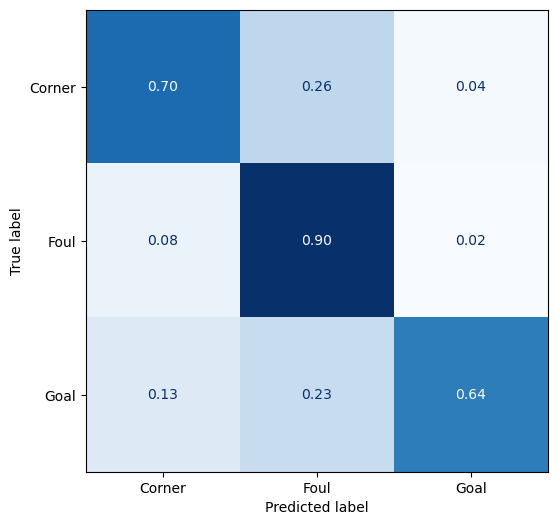

In [43]:
plot_confusion_matrix(predicted_labels_15,
                      encoded_dataset_15['test']['labels'],
                      ['Corner', 'Foul', 'Goal'],
                     filename='conf_matrix_MiniLM_15.png')

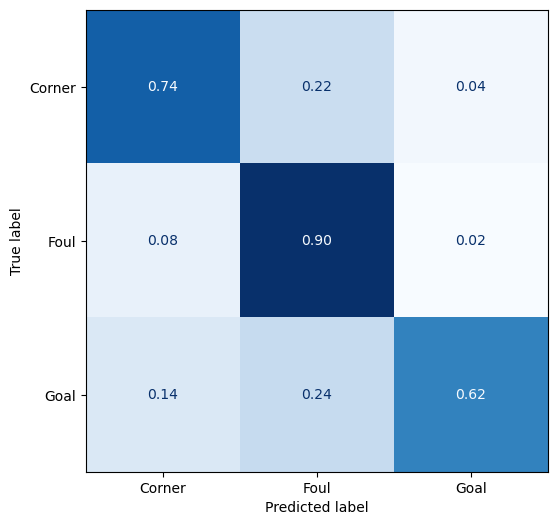

In [44]:
plot_confusion_matrix(predicted_labels_30,
                      encoded_dataset_30['test']['labels'],
                      ['Corner', 'Foul', 'Goal'],
                     filename='conf_matrix_MiniLM_30.png')

In [45]:
# Plotting the confusion matrix
#sns.heatmap(conf_matrix, annot=True, fmt='g')
#plt.xlabel('Predicted labels')
#plt.ylabel('True labels')
#plt.show()

#print(labels_name[0],':', labels[0])
#print(labels_name[1],':', labels[1])
#print(labels_name[2],':', labels[2])

In [46]:
# Learning curve 
#training_losses = loss_metric._training_losses
#validation_losses = loss_metric._validation_losses

#epochs = range(1, len(validation_losses) + 1)

#plt.figure(figsize=(10, 6))
#plt.plot(epochs, training_losses, label='Training Loss')
#plt.plot(epochs, validation_losses, label='Validation Loss')
#plt.title('Learning Curve')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()